<a href="https://colab.research.google.com/github/ethanol-lo/hurricane-predictor-time-series/blob/main/HurricanePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geodatasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize
from sklearn.model_selection import TimeSeriesSplit
import warnings
import copy
warnings.simplefilter("ignore")
plt.style.use("bmh")

In [ ]:
# run when connected to google colab runtime

atlantic = pd.read_csv("/content/atlantic.csv")
pacific = pd.read_csv("/content/pacific.csv")

Run the below code titled "preprocess data" to create all necessary feature enginnerings

# Preprocess Data

In [ ]:
df = pd.concat([atlantic, pacific])

In [ ]:
df.shape

(75242, 22)

In [ ]:
df = df.replace([-99, -999], np.nan).dropna()

In [ ]:
df = df.drop(df[df.Status == 'ET'].index)
df = df.drop(df[df.Status == 'PT'].index)
df = df.drop(df[df.Status == 'ST'].index)

In [ ]:
df.shape

(12308, 22)

In [ ]:
df['Name'] = df['Name'].str.strip()
df['Status'] = df['Status'].str.strip()
df['Event'] = df['Event'].str.strip()

In [ ]:
# Edit format of timestamps to hour:minutes:seconds

df["Time"] = df["Time"].astype("object")
time_replace = [str(x) for x in df["Time"].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, "0")
    time_replace[i] = f"{time_replace[i][0:2]}:{time_replace[i][2:4]}:00"
for old, new in zip(df["Time"].unique(), time_replace):
    df.loc[df["Time"]==old, "Time"] = new
#df["Time"].unique()

# Edit format of dates to year-day-month

df["Date"] = df["Date"].astype("object")
for i, date_str in enumerate(df["Date"].unique()):
    df.loc[df["Date"]==date_str, "Date"] = f"{str(date_str)[0:4]}-{str(date_str)[4:6]}-{str(date_str)[6:]}"

# Combine dates and timestamps

df["Datetime"] = df["Date"]+" "+df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.drop(columns=["Date", "Time"], inplace=True)
df.sort_values(by=["Datetime"], inplace=True)

In [ ]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1]=="W":
        coord *= -1
    if x[-1]=="S":
        coord *= -1
    return coord

In [ ]:
df['Latitude'] = df['Latitude'].apply(coordinate_mapping)
df['Longitude'] = df['Longitude'].apply(coordinate_mapping)

In [ ]:
df.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime
19744,EP012004,AGATHA,,TD,14.7,-107.6,25.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 00:00:00
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 06:00:00
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 12:00:00
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 18:00:00
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,75.0,25.0,25.0,25.0,25.0,0.0,0.0,0.0,0.0,2004-05-23 00:00:00


In [ ]:
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 423 individual storms from 2004 to 2015.


In [ ]:
print("Minimum Longitude:", df.Longitude.min(), "Maximum Longitude:", df.Longitude.max(), "Minimum Latitude:", df.Latitude.min(), "Maximum Latitude:", df.Latitude.max())

Minimum Longitude: -180.0 Maximum Longitude: 179.9 Minimum Latitude: 6.0 Maximum Latitude: 69.0


In [ ]:
df.loc[df.Longitude<-180, "Longitude"] = df.Longitude+360

In [ ]:
df.shape

(12308, 21)

In [ ]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude), crs={'init' :'epsg:4326'})

<Axes: >

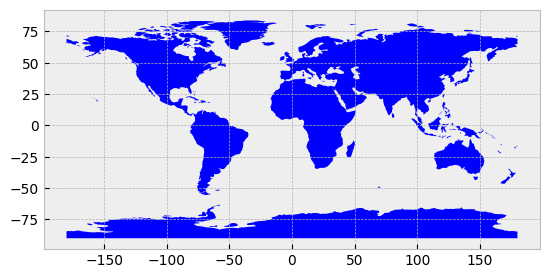

In [ ]:
# Define the URL
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.shp"

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
# Plot the world map
world.plot()

In [ ]:
gdf.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime,geometry
19744,EP012004,AGATHA,,TD,14.7,-107.6,25.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 00:00:00,POINT (-107.6 14.7)
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 06:00:00,POINT (-108.5 15.4)
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 12:00:00,POINT (-109.1 16)
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-05-22 18:00:00,POINT (-109.6 16.6)
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,25.0,25.0,25.0,25.0,0.0,0.0,0.0,0.0,2004-05-23 00:00:00,POINT (-109.9 17.1)


In [ ]:
gdf.columns

Index(['ID', 'Name', 'Event', 'Status', 'Latitude', 'Longitude',
       'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW', 'Datetime', 'geometry'],
      dtype='object')

In [ ]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf["x"] = gdf.Latitude-lat_min
gdf["x"] = gdf["x"]/gdf["x"].max()
gdf["y"] = gdf.Longitude-long_min
gdf["y"] = gdf["y"]/gdf["y"].max()

In [ ]:
print("Minimum Longitude:", gdf.x.min(), "Maximum Longitude:", gdf.x.max(), "Minimum Latitude:", gdf.y.min(), "Maximum Latitude:", gdf.y.max())

Minimum Longitude: 0.0 Maximum Longitude: 1.0 Minimum Latitude: 0.0 Maximum Latitude: 1.0


In [ ]:
gdf["relative_time"] = ((gdf.Datetime.dt.dayofyear+(gdf.Datetime.dt.hour/24.)+(gdf.Datetime.dt.minute/60.*24))/366.)

# Each day is 1/366 of a year (with 31th of december), each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [ ]:
gdf["month"] = gdf.Datetime.dt.month
gdf["hour"] = gdf.Datetime.dt.hour

In [ ]:
month_min = gdf.month.min()
gdf["month"] = gdf.month - month_min
gdf["month"] = gdf["month"] / gdf["month"].max()

In [ ]:
gdf.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,High Wind SE,High Wind SW,High Wind NW,Datetime,geometry,x,y,relative_time,month,hour
19744,EP012004,AGATHA,,TD,14.7,-107.6,25.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,2004-05-22 00:00:00,POINT (-107.6 14.7),0.138095,0.201167,0.390710,0.363636,0
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,2004-05-22 06:00:00,POINT (-108.5 15.4),0.149206,0.198666,0.391393,0.363636,6
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.0,0.0,0.0,2004-05-22 12:00:00,POINT (-109.1 16),0.158730,0.196999,0.392077,0.363636,12
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.0,0.0,0.0,2004-05-22 18:00:00,POINT (-109.6 16.6),0.168254,0.195610,0.392760,0.363636,18
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,0.0,0.0,0.0,2004-05-23 00:00:00,POINT (-109.9 17.1),0.176190,0.194776,0.393443,0.363636,0


Create vector lengths and directions and previous lengths and directions

In [ ]:
gdf["vec_x"] = np.nan
gdf["vec_y"] = np.nan
vecs = {"x": [], "y": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_x==0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x-last_x
            vec_y = row.y-last_y
            vecs["x"].append(vec_x)
            vecs["y"].append(vec_y)
            vecs["id"].append(i)
            last_x = row.x
            last_y = row.y
gdf.loc[vecs["id"], "vec_x"] = vecs["x"]
gdf.loc[vecs["id"], "vec_y"] = vecs["y"]

In [ ]:
gdf["vec_len"] = np.sqrt((gdf["vec_x"]**2)+(gdf["vec_y"]**2))

In [ ]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    if W_angle<E_angle:
        return_angle = 2*np.pi-return_angle
    return return_angle

In [ ]:
gdf["vec_direction"] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis=1)

In [ ]:
print("Minimum Longitude:", gdf.vec_len.min(), "Maximum Longitude:", gdf.vec_len.max(), "Minimum Latitude:", gdf.vec_direction.min(), "Maximum Latitude:", gdf.vec_direction.max())

Minimum Longitude: 0.0 Maximum Longitude: 0.9981357939752777 Minimum Latitude: 0.0 Maximum Latitude: 6.276822042007858


In [ ]:
# # Create data columns in gdf for previous length and previous direction

# gdf["prev_len"] = np.nan
# gdf["prev_direction"] = np.nan
# prevs = {"len": [], "direction": [], "id": []}
# for storm_id in gdf["ID"].unique():
#     last_len = False
#     last_direction = False
#     for i, row in gdf[gdf["ID"]==storm_id].iterrows():
#         if last_len==False:
#             last_len = row.vec_len
#             last_direction = row.vec_direction
#         else:
#             prevs["len"].append(last_len)
#             prevs["direction"].append(last_direction)
#             prevs["id"].append(i)
#             last_len = row.vec_len
#             last_direction = row.vec_direction
# gdf.loc[prevs["id"], "prev_len"] = prevs["len"]
# gdf.loc[prevs["id"], "prev_direction"] = prevs["direction"]

In [ ]:
# gdf["prev_len"] = np.nan
# gdf["prev_direction"] = np.nan

# gdf["prev_len"] = gdf.groupby("ID")["vec_len"].shift(1)
# gdf["prev_direction"] = gdf.groupby("ID")["vec_direction"].shift(1)

In [ ]:
gdf.shape

(12308, 31)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

gdf["wind_scaled"] = np.nan
gdf["pressure_scaled"] = np.nan

# Reshape to 2D before applying StandardScaler
wind_scaled = scaler.fit_transform(gdf["Maximum Wind"].values.reshape(-1, 1))
pressure_scaled = scaler.fit_transform(gdf["Minimum Pressure"].values.reshape(-1, 1))

gdf["wind_scaled"] = wind_scaled.flatten()
gdf["pressure_scaled"] = pressure_scaled.flatten()

In [ ]:
print("Minimum Longitude:", gdf.wind_scaled.min(), "Maximum Longitude:", gdf.wind_scaled.max(), "Minimum Latitude:", gdf.pressure_scaled.min(), "Maximum Latitude:", gdf.pressure_scaled.max())

Minimum Longitude: -1.4234645123820033 Maximum Longitude: 5.463715165766134 Minimum Latitude: -6.808046605696277 Maximum Latitude: 1.4093266629524528


In [ ]:
# gdf["prev_wind"] = np.nan
# gdf["prev_pressure"] = np.nan

# gdf["prev_wind"] = gdf.groupby("ID")["wind_scaled"].shift(1)
# gdf["prev_pressure"] = gdf.groupby("ID")["pressure_scaled"].shift(1)

In [ ]:
gdf.head(50)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,y,relative_time,month,hour,vec_x,vec_y,vec_len,vec_direction,wind_scaled,pressure_scaled
19744,EP012004,AGATHA,,TD,14.7,-107.6,25.0,1006.0,0.0,0.0,...,0.201167,0.390710,0.363636,0,NaN,NaN,NaN,NaN,-0.833135,0.582074
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.198666,0.391393,0.363636,6,0.011111,-0.002501,0.011389,1.792170,-0.636358,0.582074
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.196999,0.392077,0.363636,12,0.009524,-0.001667,0.009669,1.744089,-0.439582,0.526924
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.195610,0.392760,0.363636,18,0.009524,-0.001389,0.009625,1.715649,-0.046029,0.251173
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,0.194776,0.393443,0.363636,0,0.007937,-0.000834,0.007980,1.675442,0.150748,0.085723
19749,EP012004,AGATHA,,TS,17.5,-110.1,45.0,1000.0,50.0,50.0,...,0.194221,0.394126,0.363636,6,0.006349,-0.000556,0.006373,1.658098,-0.046029,0.251173
19750,EP012004,AGATHA,,TS,17.9,-110.3,40.0,1002.0,50.0,50.0,...,0.193665,0.394809,0.363636,12,0.006349,-0.000556,0.006373,1.658098,-0.242805,0.361474
19751,EP012004,AGATHA,,TS,18.2,-110.5,35.0,1002.0,50.0,50.0,...,0.193109,0.395492,0.363636,18,0.004762,-0.000556,0.004794,1.686970,-0.439582,0.361474
19752,EP012004,AGATHA,,TD,18.5,-110.7,30.0,1003.0,0.0,0.0,...,0.192553,0.396175,0.363636,0,0.004762,-0.000556,0.004794,1.686970,-0.636358,0.416624
19753,EP012004,AGATHA,,TD,18.7,-110.8,25.0,1005.0,0.0,0.0,...,0.192276,0.396858,0.363636,6,0.003175,-0.000278,0.003187,1.658098,-0.833135,0.526924


In [ ]:
gdf.dropna(how="any", inplace=True)
gdf.shape

(11856, 33)

In [ ]:
gdf.head(50)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,y,relative_time,month,hour,vec_x,vec_y,vec_len,vec_direction,wind_scaled,pressure_scaled
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.198666,0.391393,0.363636,6,0.011111,-0.002501,0.011389,1.792170,-0.636358,0.582074
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.196999,0.392077,0.363636,12,0.009524,-0.001667,0.009669,1.744089,-0.439582,0.526924
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.195610,0.392760,0.363636,18,0.009524,-0.001389,0.009625,1.715649,-0.046029,0.251173
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,0.194776,0.393443,0.363636,0,0.007937,-0.000834,0.007980,1.675442,0.150748,0.085723
19749,EP012004,AGATHA,,TS,17.5,-110.1,45.0,1000.0,50.0,50.0,...,0.194221,0.394126,0.363636,6,0.006349,-0.000556,0.006373,1.658098,-0.046029,0.251173
19750,EP012004,AGATHA,,TS,17.9,-110.3,40.0,1002.0,50.0,50.0,...,0.193665,0.394809,0.363636,12,0.006349,-0.000556,0.006373,1.658098,-0.242805,0.361474
19751,EP012004,AGATHA,,TS,18.2,-110.5,35.0,1002.0,50.0,50.0,...,0.193109,0.395492,0.363636,18,0.004762,-0.000556,0.004794,1.686970,-0.439582,0.361474
19752,EP012004,AGATHA,,TD,18.5,-110.7,30.0,1003.0,0.0,0.0,...,0.192553,0.396175,0.363636,0,0.004762,-0.000556,0.004794,1.686970,-0.636358,0.416624
19753,EP012004,AGATHA,,TD,18.7,-110.8,25.0,1005.0,0.0,0.0,...,0.192276,0.396858,0.363636,6,0.003175,-0.000278,0.003187,1.658098,-0.833135,0.526924
19754,EP012004,AGATHA,,LO,18.9,-110.9,25.0,1006.0,0.0,0.0,...,0.191998,0.397541,0.363636,12,0.003175,-0.000278,0.003187,1.658098,-0.833135,0.582074


In [ ]:
gdf.shape

(11856, 33)

# Time Series Feature Engineering for Lagged Data of Variable Window Size

In [ ]:
gdf.columns

Index(['ID', 'Name', 'Event', 'Status', 'Latitude', 'Longitude',
       'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW', 'Datetime', 'geometry', 'x', 'y',
       'relative_time', 'month', 'hour', 'vec_x', 'vec_y', 'vec_len',
       'vec_direction', 'wind_scaled', 'pressure_scaled'],
      dtype='object')

In [ ]:
def create_lagged_features(df, col_list, window_size):
    """
    Automatically creates lagged features for a given window size.

    :param df: Input time-series DataFrame
    :param window_size: Number of past time steps to use as features
    :return: Transformed DataFrame with lag features
    """
    df_copy = df.copy()
    for lag in range(1, window_size + 1):
        for col in col_list:
            df_copy[f"{col}_lag_{lag}"] = df.groupby("ID")[col].shift(lag)

    df_copy.dropna(inplace=True)  # Remove rows with NaN values
    return df_copy

In [ ]:
col_list = [
    'wind_scaled',
    'pressure_scaled',
    'x',
    'y',
    'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW',
    'vec_len',
    'vec_direction'
]

In [ ]:
df_lagged = create_lagged_features(gdf, col_list, 5)

In [ ]:
print(gdf.shape)
print(df_lagged.shape)

(11856, 33)
(9753, 123)


In [ ]:
gdf.head(50)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,y,relative_time,month,hour,vec_x,vec_y,vec_len,vec_direction,wind_scaled,pressure_scaled
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.198666,0.391393,0.363636,6,0.011111,-0.002501,0.011389,1.792170,-0.636358,0.582074
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.196999,0.392077,0.363636,12,0.009524,-0.001667,0.009669,1.744089,-0.439582,0.526924
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.195610,0.392760,0.363636,18,0.009524,-0.001389,0.009625,1.715649,-0.046029,0.251173
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,0.194776,0.393443,0.363636,0,0.007937,-0.000834,0.007980,1.675442,0.150748,0.085723
19749,EP012004,AGATHA,,TS,17.5,-110.1,45.0,1000.0,50.0,50.0,...,0.194221,0.394126,0.363636,6,0.006349,-0.000556,0.006373,1.658098,-0.046029,0.251173
19750,EP012004,AGATHA,,TS,17.9,-110.3,40.0,1002.0,50.0,50.0,...,0.193665,0.394809,0.363636,12,0.006349,-0.000556,0.006373,1.658098,-0.242805,0.361474
19751,EP012004,AGATHA,,TS,18.2,-110.5,35.0,1002.0,50.0,50.0,...,0.193109,0.395492,0.363636,18,0.004762,-0.000556,0.004794,1.686970,-0.439582,0.361474
19752,EP012004,AGATHA,,TD,18.5,-110.7,30.0,1003.0,0.0,0.0,...,0.192553,0.396175,0.363636,0,0.004762,-0.000556,0.004794,1.686970,-0.636358,0.416624
19753,EP012004,AGATHA,,TD,18.7,-110.8,25.0,1005.0,0.0,0.0,...,0.192276,0.396858,0.363636,6,0.003175,-0.000278,0.003187,1.658098,-0.833135,0.526924
19754,EP012004,AGATHA,,LO,18.9,-110.9,25.0,1006.0,0.0,0.0,...,0.191998,0.397541,0.363636,12,0.003175,-0.000278,0.003187,1.658098,-0.833135,0.582074


In [ ]:
df_lagged[df_lagged.Name == 'KATRINA']

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE_lag_5,Moderate Wind SE_lag_5,Moderate Wind SW_lag_5,Moderate Wind NW_lag_5,High Wind NE_lag_5,High Wind SE_lag_5,High Wind SW_lag_5,High Wind NW_lag_5,vec_len_lag_5,vec_direction_lag_5
44069,AL122005,KATRINA,,TS,26.1,-78.4,50.0,997.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005045,1.907558
44070,AL122005,KATRINA,,TS,26.2,-79.0,55.0,994.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006499,1.786212
44071,AL122005,KATRINA,,TS,26.2,-79.6,60.0,988.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011142,1.645677
44073,AL122005,KATRINA,,HU,25.9,-80.3,70.0,983.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014329,1.648439
44074,AL122005,KATRINA,,HU,25.4,-81.3,65.0,987.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009780,1.800090
44075,AL122005,KATRINA,,HU,25.1,-82.0,75.0,979.0,75.0,75.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002510,2.457112
44076,AL122005,KATRINA,,HU,24.9,-82.6,85.0,968.0,75.0,75.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002302,2.380719
44077,AL122005,KATRINA,,HU,24.6,-83.3,90.0,959.0,90.0,75.0,...,25.0,25.0,20.0,20.0,0.0,0.0,0.0,0.0,0.001667,3.141593
44078,AL122005,KATRINA,,HU,24.4,-84.0,95.0,950.0,130.0,90.0,...,20.0,20.0,20.0,20.0,10.0,10.0,10.0,10.0,0.005144,4.324622
44079,AL122005,KATRINA,,HU,24.4,-84.7,100.0,942.0,130.0,90.0,...,60.0,60.0,20.0,20.0,10.0,10.0,10.0,10.0,0.008409,4.375628


In [ ]:
# df_lagged.columns[8:20]

In [ ]:
# df_lagged = df_lagged.drop(df_lagged.columns[8:20], axis=1)

In [ ]:
df_lagged.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE_lag_5,Moderate Wind SE_lag_5,Moderate Wind SW_lag_5,Moderate Wind NW_lag_5,High Wind NE_lag_5,High Wind SE_lag_5,High Wind SW_lag_5,High Wind NW_lag_5,vec_len_lag_5,vec_direction_lag_5
19750,EP012004,AGATHA,,TS,17.9,-110.3,40.0,1002.0,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011389,1.792170
19751,EP012004,AGATHA,,TS,18.2,-110.5,35.0,1002.0,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009669,1.744089
19752,EP012004,AGATHA,,TD,18.5,-110.7,30.0,1003.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009625,1.715649
19753,EP012004,AGATHA,,TD,18.7,-110.8,25.0,1005.0,0.0,0.0,...,25.0,25.0,25.0,25.0,0.0,0.0,0.0,0.0,0.007980,1.675442
19754,EP012004,AGATHA,,LO,18.9,-110.9,25.0,1006.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006373,1.658098


In [ ]:
df_lagged.columns

Index(['ID', 'Name', 'Event', 'Status', 'Latitude', 'Longitude',
       'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       ...
       'Moderate Wind NE_lag_5', 'Moderate Wind SE_lag_5',
       'Moderate Wind SW_lag_5', 'Moderate Wind NW_lag_5',
       'High Wind NE_lag_5', 'High Wind SE_lag_5', 'High Wind SW_lag_5',
       'High Wind NW_lag_5', 'vec_len_lag_5', 'vec_direction_lag_5'],
      dtype='object', length=123)

# Extract Hurricane Katrina Data (for later test case)



In [ ]:
df_lagged[df_lagged.Name=="KATRINA"].ID.unique()

array(['AL122005'], dtype=object)

In [ ]:
gdf_kat = df_lagged[df_lagged.Name=="KATRINA"]

In [ ]:
df_lagged = df_lagged[df_lagged.ID != 'AL122005']

In [ ]:
gdf_kat.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE_lag_5,Moderate Wind SE_lag_5,Moderate Wind SW_lag_5,Moderate Wind NW_lag_5,High Wind NE_lag_5,High Wind SE_lag_5,High Wind SW_lag_5,High Wind NW_lag_5,vec_len_lag_5,vec_direction_lag_5
44069,AL122005,KATRINA,,TS,26.1,-78.4,50.0,997.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005045,1.907558
44070,AL122005,KATRINA,,TS,26.2,-79.0,55.0,994.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006499,1.786212
44071,AL122005,KATRINA,,TS,26.2,-79.6,60.0,988.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011142,1.645677
44073,AL122005,KATRINA,,HU,25.9,-80.3,70.0,983.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014329,1.648439
44074,AL122005,KATRINA,,HU,25.4,-81.3,65.0,987.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009780,1.800090


In [ ]:
gdf_kat.shape

(25, 123)

In [ ]:
gdf.shape

(11856, 33)

# Regression: Predicting Numerical Characteristics

In [ ]:
print(list(df_lagged.columns))

['ID', 'Name', 'Event', 'Status', 'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'Datetime', 'geometry', 'x', 'y', 'relative_time', 'month', 'hour', 'vec_x', 'vec_y', 'vec_len', 'vec_direction', 'wind_scaled', 'pressure_scaled', 'wind_scaled_lag_1', 'pressure_scaled_lag_1', 'x_lag_1', 'y_lag_1', 'Low Wind NE_lag_1', 'Low Wind SE_lag_1', 'Low Wind SW_lag_1', 'Low Wind NW_lag_1', 'Moderate Wind NE_lag_1', 'Moderate Wind SE_lag_1', 'Moderate Wind SW_lag_1', 'Moderate Wind NW_lag_1', 'High Wind NE_lag_1', 'High Wind SE_lag_1', 'High Wind SW_lag_1', 'High Wind NW_lag_1', 'vec_len_lag_1', 'vec_direction_lag_1', 'wind_scaled_lag_2', 'pressure_scaled_lag_2', 'x_lag_2', 'y_lag_2', 'Low Wind NE_lag_2', 'Low Wind SE_lag_2', 'Low Wind SW_lag_2', 'Low Wind NW_lag_2', 'Moderate Wind NE

In [ ]:
drop_col_list = [
    'ID',
    'Name',
    'Event',
    'Status',
    'Latitude',
    'Longitude',
    'Maximum Wind',
    'Minimum Pressure',
    'Low Wind NE',
    'Low Wind SE',
    'Low Wind SW',
    'Low Wind NW',
    'Moderate Wind NE',
    'Moderate Wind SE',
    'Moderate Wind SW',
    'Moderate Wind NW',
    'High Wind NE',
    'High Wind SE',
    'High Wind SW',
    'High Wind NW',
    'Datetime',
    'geometry',
    'x',
    'y',
    'relative_time',
    'hour',
    'vec_x',
    'vec_y',
    'vec_len',
    'vec_direction',
    'wind_scaled',
    'pressure_scaled'
    ]

# drop everything except month and lagged data
X_direction = df_lagged.drop(columns=drop_col_list)
y_direction = df_lagged['vec_direction']

X_length = df_lagged.drop(columns=drop_col_list)
y_length = df_lagged['vec_len']

X_features = df_lagged.drop(columns=drop_col_list)

y_wind = df_lagged['wind_scaled']

y_pressure = df_lagged['pressure_scaled']

Either split the data or use cross validation with TimeSeriesSplit

In [ ]:
X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(X_features, y_wind, test_size=0.2, random_state = 42)
X_pressure_train, X_pressure_test, y_pressure_train, y_pressure_test = train_test_split(X_features, y_pressure, test_size=0.2, random_state = 42)
X_direction_train, X_direction_test, y_direction_train, y_direction_test = train_test_split(X_direction, y_direction, test_size=0.2, random_state=42)
X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y_length, test_size=0.2, random_state=42)

In [ ]:
# # CV for direction
# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, test_index in tscv.split(X_direction):
#     X_direction_train, X_direction_test = X_direction.iloc[train_index], X_direction.iloc[test_index]
#     y_direction_train, y_direction_test = y_direction.iloc[train_index], y_direction.iloc[test_index]

In [ ]:
# # CV for length

# for train_index, test_index in tscv.split(X_length):
#     X_length_train, X_length_test = X_length.iloc[train_index], X_length.iloc[test_index]
#     y_length_train, y_length_test = y_length.iloc[train_index], y_length.iloc[test_index]

In [ ]:
# # CV for wind

# for train_index, test_index in tscv.split(X_features):
#     X_wind_train, X_wind_test = X_features.iloc[train_index], X_features.iloc[test_index]
#     y_wind_train, y_wind_test = y_wind.iloc[train_index], y_wind.iloc[test_index]

In [ ]:
# # CV for pressure

# for train_index, test_index in tscv.split(X_features):
#     X_pressure_train, X_pressure_test = X_features.iloc[train_index], X_features.iloc[test_index]
#     y_pressure_train, y_pressure_test = y_pressure.iloc[train_index], y_pressure.iloc[test_index]

In [ ]:
X_features.shape

(9728, 91)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Fit model and predict values

In [ ]:
model_pressure = GradientBoostingRegressor(loss='absolute_error', max_depth=10,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=7, n_estimators=124).fit(X_pressure_train, y_pressure_train)

# model_pressure = GradientBoostingRegressor().fit(X_pressure_train, y_pressure_train)

pressure_predictions = model_pressure.predict(X_pressure_test)

# print(predictions, y_pressure_test)

print(f"MAE: {mean_absolute_error(y_pressure_test, pressure_predictions)}")
print(f"r2 score: {r2_score(y_pressure_test, pressure_predictions)}")

MAE: 0.12240869591242667
r2 score: 0.9620452407719152


In [ ]:
# model_wind = GradientBoostingRegressor(learning_rate=0.013735687772822771,
#                           loss='absolute_error', max_depth=9,
#                           max_features='log2', min_samples_leaf=4,
#                           min_samples_split=8, n_estimators=147).fit(X_wind_train, y_wind_train)

model_wind = GradientBoostingRegressor(loss='absolute_error', max_depth=6,
                          max_features='sqrt', min_samples_leaf=4,
                          min_samples_split=5, n_estimators=142).fit(X_wind_train, y_wind_train)

wind_predictions = model_wind.predict(X_wind_test)

# print(predictions, y_wind_test)

print(f"MAE: {mean_absolute_error(y_wind_test, wind_predictions)}")
print(f"r2 score: {r2_score(y_wind_test, wind_predictions)}")

MAE: 0.1333603222669016
r2 score: 0.9611366364976419


In [ ]:
model_direction = GradientBoostingRegressor(loss='absolute_error', max_depth=11,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=6, n_estimators=105).fit(X_direction_train, y_direction_train)

direction_predictions = model_direction.predict(X_direction_test)

print(f"MAE: {mean_absolute_error(y_direction_test, direction_predictions)}")
print(f"R2: {r2_score(y_direction_test, direction_predictions)}")

MAE: 0.3694784392003572
R2: 0.6114127163724046


In [ ]:
model_length = GradientBoostingRegressor(loss='absolute_error', max_depth=7,
                          max_features='sqrt', min_samples_leaf=2,
                          min_samples_split=5, n_estimators=117).fit(X_length_train, y_length_train)

len_predictions = model_length.predict(X_length_test)

print(f"MAE: {mean_absolute_error(y_length_test, len_predictions)}")
print(f"R2: {r2_score(y_length_test, len_predictions)}")

MAE: 0.003089264280250178
R2: 0.2615642028169929


# Convert MAE to interpretable values

In [ ]:
pressure_pred_denorm = scaler.inverse_transform(pressure_predictions.reshape(-1, 1))
wind_pred_denorm = scaler.inverse_transform(wind_predictions.reshape(-1, 1))

pressure_pred_denorm.flatten()
wind_pred_denorm.flatten()

pressure_real_denorm = scaler.inverse_transform(y_pressure_test.to_frame())
wind_real_denorm = scaler.inverse_transform(y_wind_test.to_frame())

pressure_real_denorm.flatten()
wind_pred_denorm.flatten()

print(f"Pressure MAE: {mean_absolute_error(pressure_real_denorm, pressure_pred_denorm)} bar")
print(f"Wind MAE: {mean_absolute_error(wind_real_denorm, wind_pred_denorm)} kn")

Pressure MAE: 2.219553024387657 bar
Wind MAE: 2.418131362436683 kn


In [ ]:
import numpy as np

# Constants for conversion
LAT_TO_KM = 111  # Approximate conversion: 1 degree latitude ≈ 111 km
mean_lat = gdf["Latitude"].mean()
LON_TO_KM = 111 * np.cos(np.radians(mean_lat))  # Convert longitude degrees to km

# Compute actual displacements in lat/lon space
gdf["lat_diff"] = gdf["Latitude"].diff()
gdf["lon_diff"] = gdf["Longitude"].diff()

# Convert stepwise lat/lon differences to km
gdf["step_vec_x"] = gdf["lat_diff"] * LAT_TO_KM
gdf["step_vec_y"] = gdf["lon_diff"] * LON_TO_KM

# Compute actual (non-normalized) vector lengths in km
gdf["step_vec_len"] = np.sqrt(gdf["step_vec_x"]**2 + gdf["step_vec_y"]**2)

# Compute maximum vector length BEFORE normalization (to get scaling factor)
max_real_vec_len = gdf["step_vec_len"].max()

# Compute Mean Absolute Error (MAE) of normalized vector length
actual_values = y_length_test  # Actual normalized vector lengths
mae_vec_len_norm = np.mean(np.abs(len_predictions - actual_values))  # MAE in normalized space

# Denormalize the MAE using the correct scale
mae_vec_len_km = mae_vec_len_norm * max_real_vec_len

# Print results
print(f"Corrected MAE of vector length in km: {mae_vec_len_km:.2f} km")


Corrected MAE of vector length in km: 114.24 km


# Feature Importances

In [ ]:
!pip install shap

In [ ]:
import shap

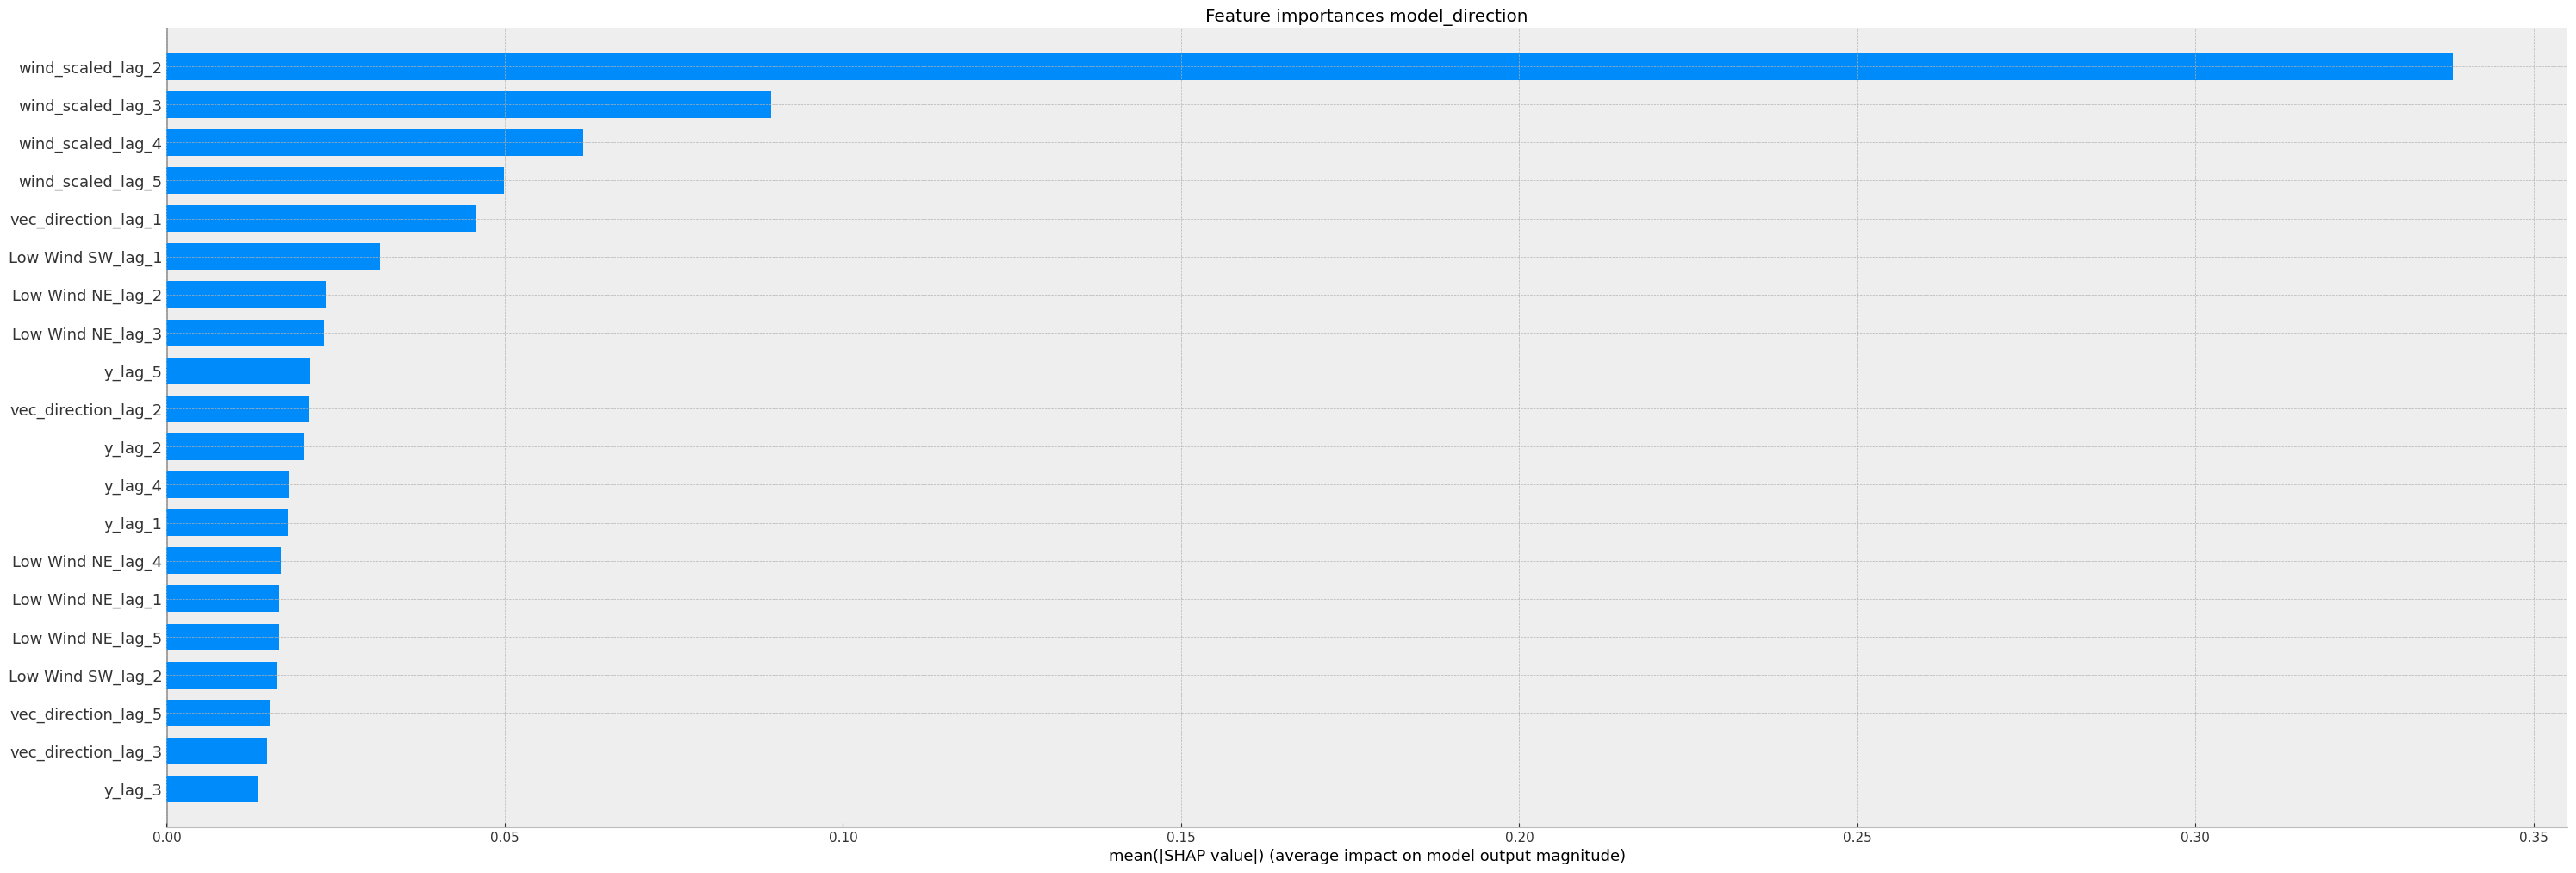

In [ ]:
explainer_features = shap.TreeExplainer(model_direction)
shap_values_features = explainer_features.shap_values(X_direction_test)
shap.summary_plot(shap_values_features, X_direction_test, plot_type="bar",
                  feature_names=['wind_scaled_lag_1', 'pressure_scaled_lag_1', 'x_lag_1', 'y_lag_1', 'Low Wind NE_lag_1', 'Low Wind SE_lag_1', 'Low Wind SW_lag_1', 'Low Wind NW_lag_1', 'Moderate Wind NE_lag_1', 'Moderate Wind SE_lag_1', 'Moderate Wind SW_lag_1', 'Moderate Wind NW_lag_1', 'High Wind NE_lag_1', 'High Wind SE_lag_1', 'High Wind SW_lag_1', 'High Wind NW_lag_1', 'vec_len_lag_1', 'vec_direction_lag_1', 'wind_scaled_lag_2', 'pressure_scaled_lag_2', 'x_lag_2', 'y_lag_2', 'Low Wind NE_lag_2', 'Low Wind SE_lag_2', 'Low Wind SW_lag_2', 'Low Wind NW_lag_2', 'Moderate Wind NE_lag_2', 'Moderate Wind SE_lag_2', 'Moderate Wind SW_lag_2', 'Moderate Wind NW_lag_2', 'High Wind NE_lag_2', 'High Wind SE_lag_2', 'High Wind SW_lag_2', 'High Wind NW_lag_2', 'vec_len_lag_2', 'vec_direction_lag_2', 'wind_scaled_lag_3', 'pressure_scaled_lag_3', 'x_lag_3', 'y_lag_3', 'Low Wind NE_lag_3', 'Low Wind SE_lag_3', 'Low Wind SW_lag_3', 'Low Wind NW_lag_3', 'Moderate Wind NE_lag_3', 'Moderate Wind SE_lag_3', 'Moderate Wind SW_lag_3', 'Moderate Wind NW_lag_3', 'High Wind NE_lag_3', 'High Wind SE_lag_3', 'High Wind SW_lag_3', 'High Wind NW_lag_3', 'vec_len_lag_3', 'vec_direction_lag_3', 'wind_scaled_lag_4', 'pressure_scaled_lag_4', 'x_lag_4', 'y_lag_4', 'Low Wind NE_lag_4', 'Low Wind SE_lag_4', 'Low Wind SW_lag_4', 'Low Wind NW_lag_4', 'Moderate Wind NE_lag_4', 'Moderate Wind SE_lag_4', 'Moderate Wind SW_lag_4', 'Moderate Wind NW_lag_4', 'High Wind NE_lag_4', 'High Wind SE_lag_4', 'High Wind SW_lag_4', 'High Wind NW_lag_4', 'vec_len_lag_4', 'vec_direction_lag_4', 'wind_scaled_lag_5', 'pressure_scaled_lag_5', 'x_lag_5', 'y_lag_5', 'Low Wind NE_lag_5', 'Low Wind SE_lag_5', 'Low Wind SW_lag_5', 'Low Wind NW_lag_5', 'Moderate Wind NE_lag_5', 'Moderate Wind SE_lag_5', 'Moderate Wind SW_lag_5', 'Moderate Wind NW_lag_5', 'High Wind NE_lag_5', 'High Wind SE_lag_5', 'High Wind SW_lag_5', 'High Wind NW_lag_5', 'vec_len_lag_5', 'vec_direction_lag_5', 'month'],
                  show=False, plot_size=(30,10))

plt.title("Feature importances model_direction")
plt.show()

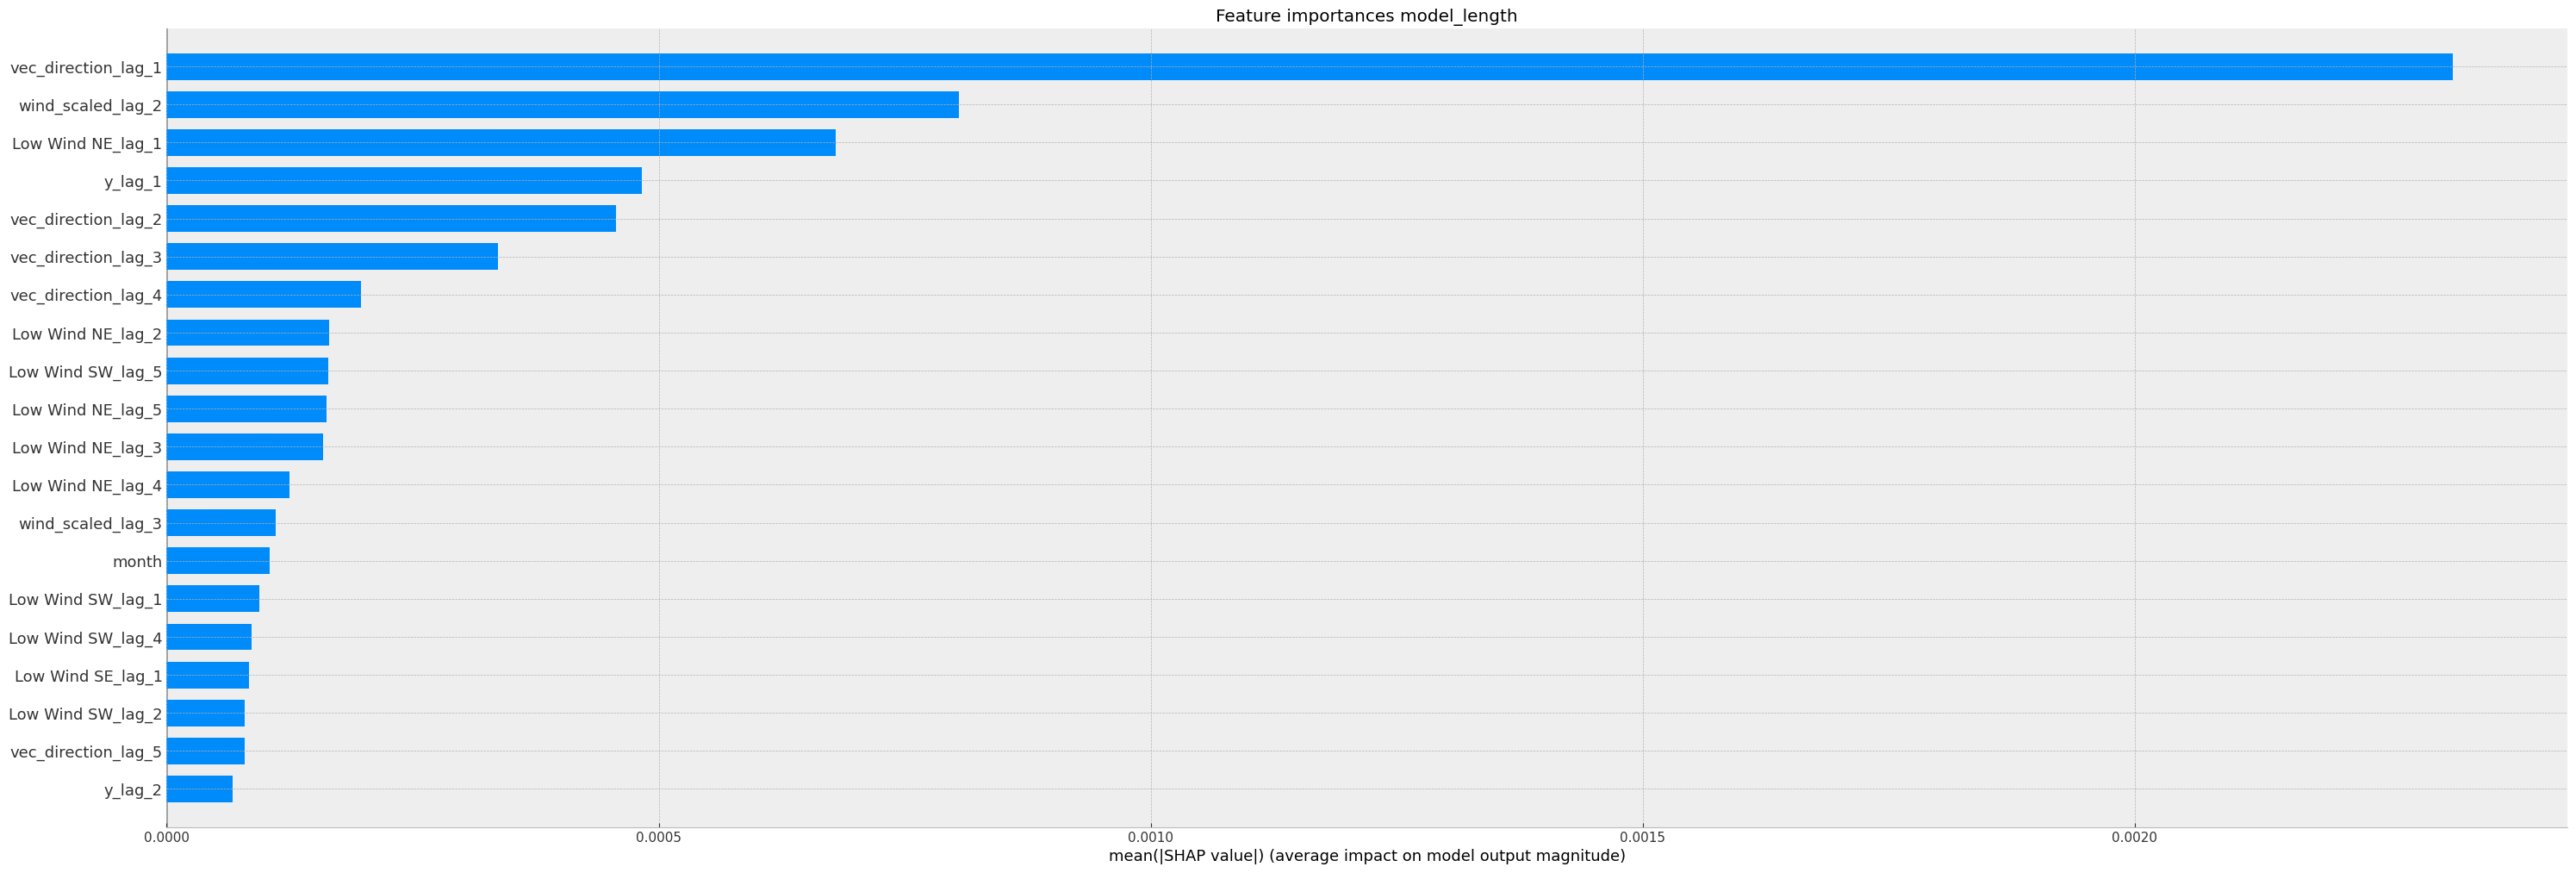

In [ ]:
explainer_features = shap.TreeExplainer(model_length)
shap_values_features = explainer_features.shap_values(X_length_test)
shap.summary_plot(shap_values_features, X_length_test, plot_type="bar",
                  feature_names=['wind_scaled_lag_1', 'pressure_scaled_lag_1', 'x_lag_1', 'y_lag_1', 'Low Wind NE_lag_1', 'Low Wind SE_lag_1', 'Low Wind SW_lag_1', 'Low Wind NW_lag_1', 'Moderate Wind NE_lag_1', 'Moderate Wind SE_lag_1', 'Moderate Wind SW_lag_1', 'Moderate Wind NW_lag_1', 'High Wind NE_lag_1', 'High Wind SE_lag_1', 'High Wind SW_lag_1', 'High Wind NW_lag_1', 'vec_len_lag_1', 'vec_direction_lag_1', 'wind_scaled_lag_2', 'pressure_scaled_lag_2', 'x_lag_2', 'y_lag_2', 'Low Wind NE_lag_2', 'Low Wind SE_lag_2', 'Low Wind SW_lag_2', 'Low Wind NW_lag_2', 'Moderate Wind NE_lag_2', 'Moderate Wind SE_lag_2', 'Moderate Wind SW_lag_2', 'Moderate Wind NW_lag_2', 'High Wind NE_lag_2', 'High Wind SE_lag_2', 'High Wind SW_lag_2', 'High Wind NW_lag_2', 'vec_len_lag_2', 'vec_direction_lag_2', 'wind_scaled_lag_3', 'pressure_scaled_lag_3', 'x_lag_3', 'y_lag_3', 'Low Wind NE_lag_3', 'Low Wind SE_lag_3', 'Low Wind SW_lag_3', 'Low Wind NW_lag_3', 'Moderate Wind NE_lag_3', 'Moderate Wind SE_lag_3', 'Moderate Wind SW_lag_3', 'Moderate Wind NW_lag_3', 'High Wind NE_lag_3', 'High Wind SE_lag_3', 'High Wind SW_lag_3', 'High Wind NW_lag_3', 'vec_len_lag_3', 'vec_direction_lag_3', 'wind_scaled_lag_4', 'pressure_scaled_lag_4', 'x_lag_4', 'y_lag_4', 'Low Wind NE_lag_4', 'Low Wind SE_lag_4', 'Low Wind SW_lag_4', 'Low Wind NW_lag_4', 'Moderate Wind NE_lag_4', 'Moderate Wind SE_lag_4', 'Moderate Wind SW_lag_4', 'Moderate Wind NW_lag_4', 'High Wind NE_lag_4', 'High Wind SE_lag_4', 'High Wind SW_lag_4', 'High Wind NW_lag_4', 'vec_len_lag_4', 'vec_direction_lag_4', 'wind_scaled_lag_5', 'pressure_scaled_lag_5', 'x_lag_5', 'y_lag_5', 'Low Wind NE_lag_5', 'Low Wind SE_lag_5', 'Low Wind SW_lag_5', 'Low Wind NW_lag_5', 'Moderate Wind NE_lag_5', 'Moderate Wind SE_lag_5', 'Moderate Wind SW_lag_5', 'Moderate Wind NW_lag_5', 'High Wind NE_lag_5', 'High Wind SE_lag_5', 'High Wind SW_lag_5', 'High Wind NW_lag_5', 'vec_len_lag_5', 'vec_direction_lag_5', 'month'],
                  show=False, plot_size=(30,10))

plt.title("Feature importances model_length")
plt.show()

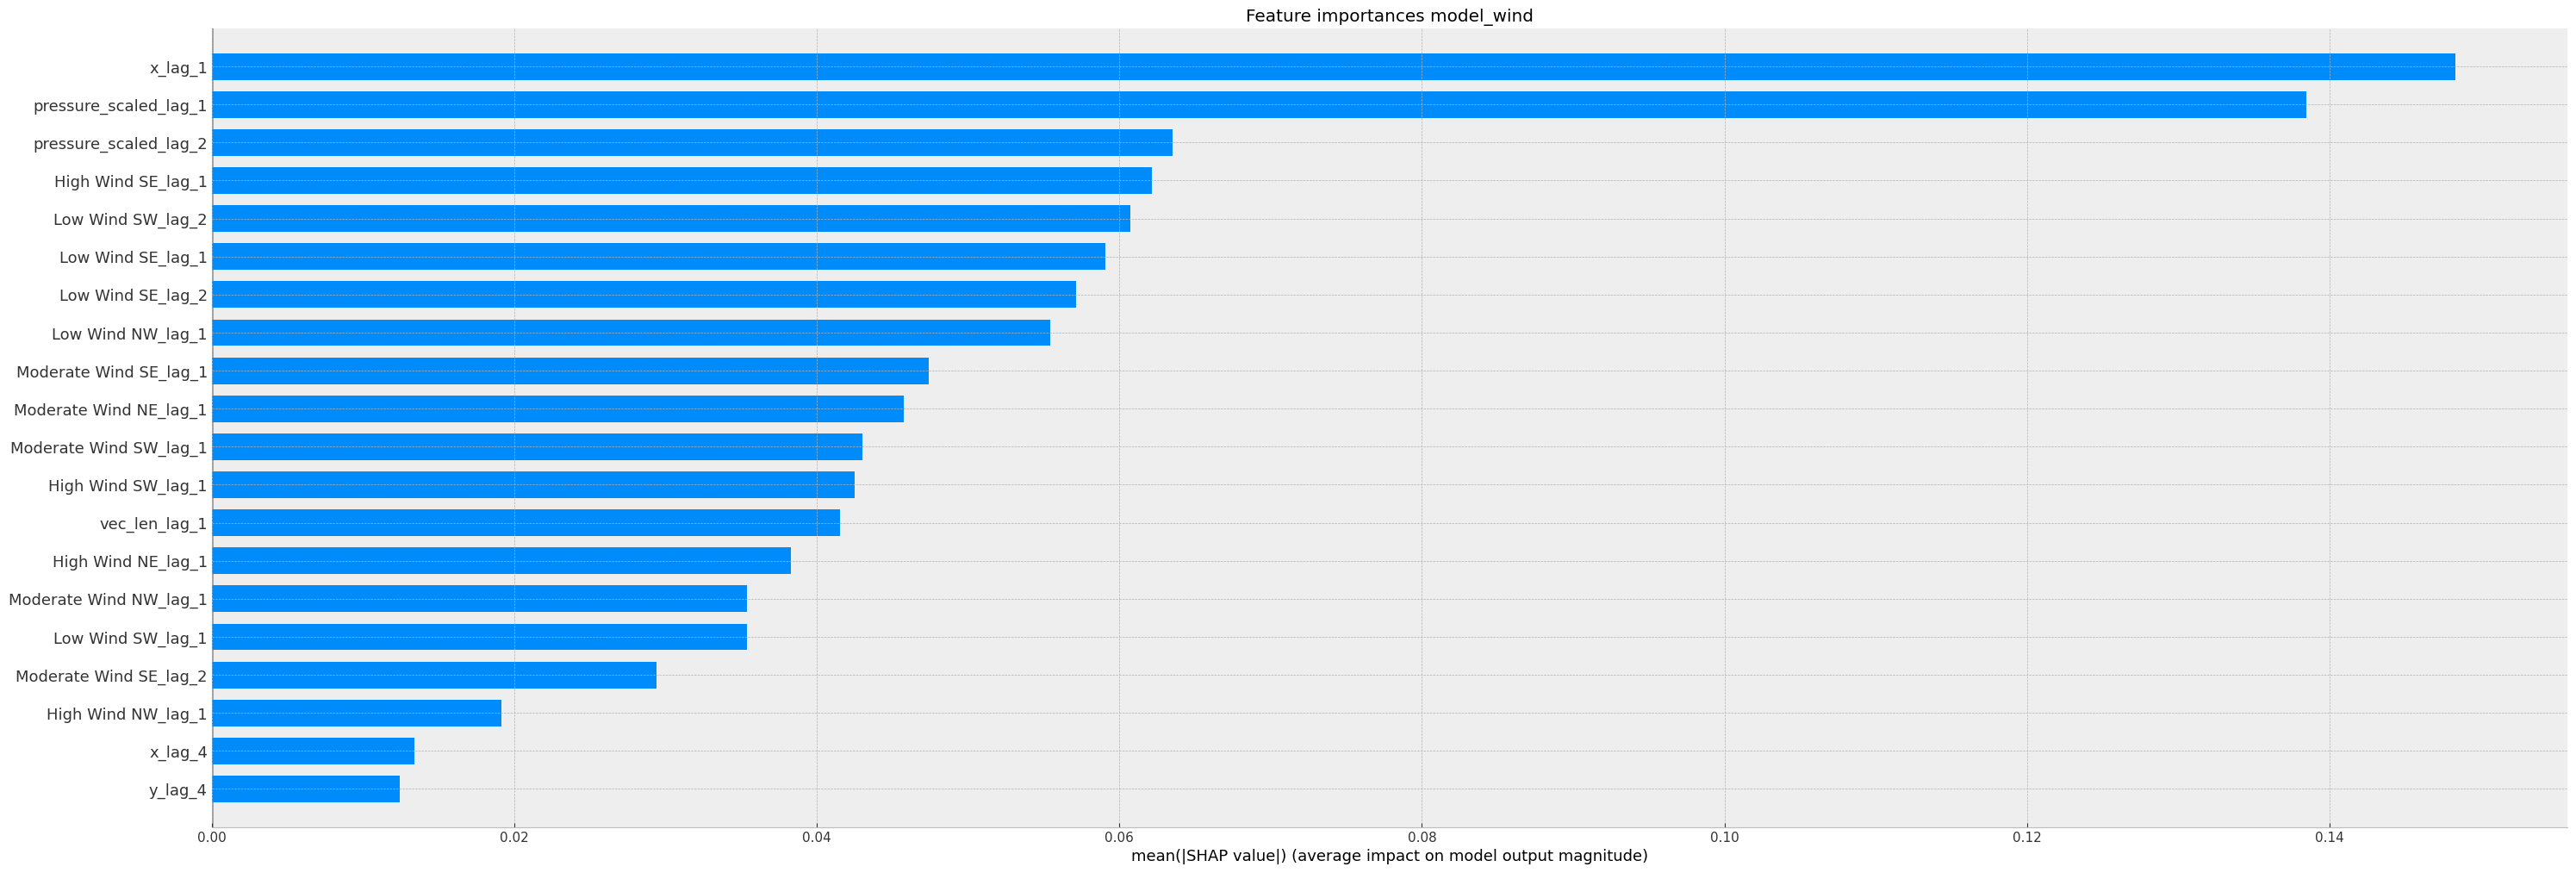

In [ ]:
explainer_features = shap.TreeExplainer(model_wind)
shap_values_features = explainer_features.shap_values(X_wind_test)
shap.summary_plot(shap_values_features, X_wind_test, plot_type="bar",
                  feature_names=['wind_scaled_lag_1', 'pressure_scaled_lag_1', 'x_lag_1', 'y_lag_1', 'Low Wind NE_lag_1', 'Low Wind SE_lag_1', 'Low Wind SW_lag_1', 'Low Wind NW_lag_1', 'Moderate Wind NE_lag_1', 'Moderate Wind SE_lag_1', 'Moderate Wind SW_lag_1', 'Moderate Wind NW_lag_1', 'High Wind NE_lag_1', 'High Wind SE_lag_1', 'High Wind SW_lag_1', 'High Wind NW_lag_1', 'vec_len_lag_1', 'vec_direction_lag_1', 'wind_scaled_lag_2', 'pressure_scaled_lag_2', 'x_lag_2', 'y_lag_2', 'Low Wind NE_lag_2', 'Low Wind SE_lag_2', 'Low Wind SW_lag_2', 'Low Wind NW_lag_2', 'Moderate Wind NE_lag_2', 'Moderate Wind SE_lag_2', 'Moderate Wind SW_lag_2', 'Moderate Wind NW_lag_2', 'High Wind NE_lag_2', 'High Wind SE_lag_2', 'High Wind SW_lag_2', 'High Wind NW_lag_2', 'vec_len_lag_2', 'vec_direction_lag_2', 'wind_scaled_lag_3', 'pressure_scaled_lag_3', 'x_lag_3', 'y_lag_3', 'Low Wind NE_lag_3', 'Low Wind SE_lag_3', 'Low Wind SW_lag_3', 'Low Wind NW_lag_3', 'Moderate Wind NE_lag_3', 'Moderate Wind SE_lag_3', 'Moderate Wind SW_lag_3', 'Moderate Wind NW_lag_3', 'High Wind NE_lag_3', 'High Wind SE_lag_3', 'High Wind SW_lag_3', 'High Wind NW_lag_3', 'vec_len_lag_3', 'vec_direction_lag_3', 'wind_scaled_lag_4', 'pressure_scaled_lag_4', 'x_lag_4', 'y_lag_4', 'Low Wind NE_lag_4', 'Low Wind SE_lag_4', 'Low Wind SW_lag_4', 'Low Wind NW_lag_4', 'Moderate Wind NE_lag_4', 'Moderate Wind SE_lag_4', 'Moderate Wind SW_lag_4', 'Moderate Wind NW_lag_4', 'High Wind NE_lag_4', 'High Wind SE_lag_4', 'High Wind SW_lag_4', 'High Wind NW_lag_4', 'vec_len_lag_4', 'vec_direction_lag_4', 'wind_scaled_lag_5', 'pressure_scaled_lag_5', 'x_lag_5', 'y_lag_5', 'Low Wind NE_lag_5', 'Low Wind SE_lag_5', 'Low Wind SW_lag_5', 'Low Wind NW_lag_5', 'Moderate Wind NE_lag_5', 'Moderate Wind SE_lag_5', 'Moderate Wind SW_lag_5', 'Moderate Wind NW_lag_5', 'High Wind NE_lag_5', 'High Wind SE_lag_5', 'High Wind SW_lag_5', 'High Wind NW_lag_5', 'vec_len_lag_5', 'vec_direction_lag_5', 'month'],
                  show=False, plot_size=(30,10))

plt.title("Feature importances model_wind")
plt.show()

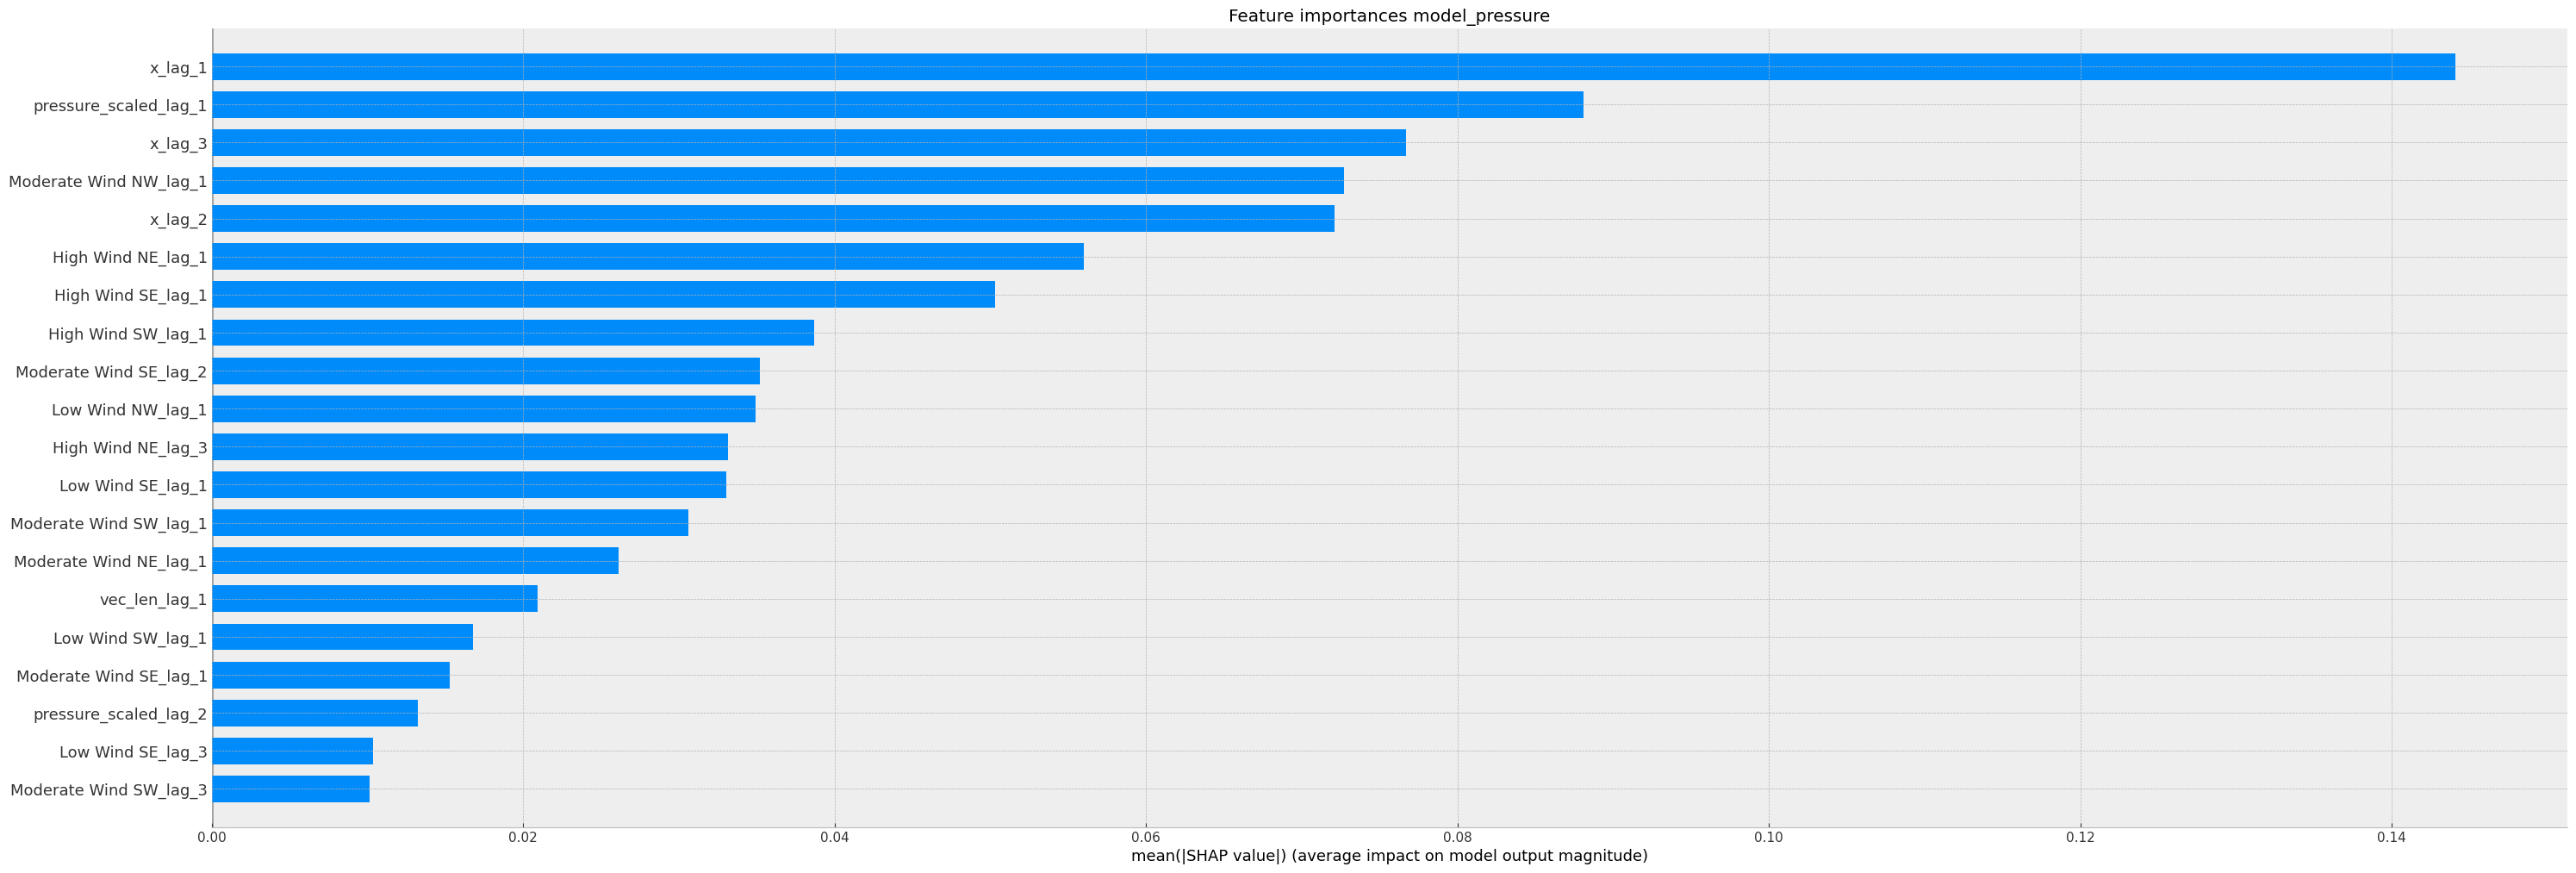

In [ ]:
explainer_features = shap.TreeExplainer(model_pressure)
shap_values_features = explainer_features.shap_values(X_pressure_test)
shap.summary_plot(shap_values_features, X_pressure_test, plot_type="bar",
                  feature_names=['wind_scaled_lag_1', 'pressure_scaled_lag_1', 'x_lag_1', 'y_lag_1', 'Low Wind NE_lag_1', 'Low Wind SE_lag_1', 'Low Wind SW_lag_1', 'Low Wind NW_lag_1', 'Moderate Wind NE_lag_1', 'Moderate Wind SE_lag_1', 'Moderate Wind SW_lag_1', 'Moderate Wind NW_lag_1', 'High Wind NE_lag_1', 'High Wind SE_lag_1', 'High Wind SW_lag_1', 'High Wind NW_lag_1', 'vec_len_lag_1', 'vec_direction_lag_1', 'wind_scaled_lag_2', 'pressure_scaled_lag_2', 'x_lag_2', 'y_lag_2', 'Low Wind NE_lag_2', 'Low Wind SE_lag_2', 'Low Wind SW_lag_2', 'Low Wind NW_lag_2', 'Moderate Wind NE_lag_2', 'Moderate Wind SE_lag_2', 'Moderate Wind SW_lag_2', 'Moderate Wind NW_lag_2', 'High Wind NE_lag_2', 'High Wind SE_lag_2', 'High Wind SW_lag_2', 'High Wind NW_lag_2', 'vec_len_lag_2', 'vec_direction_lag_2', 'wind_scaled_lag_3', 'pressure_scaled_lag_3', 'x_lag_3', 'y_lag_3', 'Low Wind NE_lag_3', 'Low Wind SE_lag_3', 'Low Wind SW_lag_3', 'Low Wind NW_lag_3', 'Moderate Wind NE_lag_3', 'Moderate Wind SE_lag_3', 'Moderate Wind SW_lag_3', 'Moderate Wind NW_lag_3', 'High Wind NE_lag_3', 'High Wind SE_lag_3', 'High Wind SW_lag_3', 'High Wind NW_lag_3', 'vec_len_lag_3', 'vec_direction_lag_3', 'wind_scaled_lag_4', 'pressure_scaled_lag_4', 'x_lag_4', 'y_lag_4', 'Low Wind NE_lag_4', 'Low Wind SE_lag_4', 'Low Wind SW_lag_4', 'Low Wind NW_lag_4', 'Moderate Wind NE_lag_4', 'Moderate Wind SE_lag_4', 'Moderate Wind SW_lag_4', 'Moderate Wind NW_lag_4', 'High Wind NE_lag_4', 'High Wind SE_lag_4', 'High Wind SW_lag_4', 'High Wind NW_lag_4', 'vec_len_lag_4', 'vec_direction_lag_4', 'wind_scaled_lag_5', 'pressure_scaled_lag_5', 'x_lag_5', 'y_lag_5', 'Low Wind NE_lag_5', 'Low Wind SE_lag_5', 'Low Wind SW_lag_5', 'Low Wind NW_lag_5', 'Moderate Wind NE_lag_5', 'Moderate Wind SE_lag_5', 'Moderate Wind SW_lag_5', 'Moderate Wind NW_lag_5', 'High Wind NE_lag_5', 'High Wind SE_lag_5', 'High Wind SW_lag_5', 'High Wind NW_lag_5', 'vec_len_lag_5', 'vec_direction_lag_5', 'month'],
                  show=False, plot_size=(30,10))

plt.title("Feature importances model_pressure")
plt.show()

# Hyperparameter Tuning for Regression

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
col_list_tune = ['wind_scaled',
    'pressure_scaled',
    'x',
    'y',
    'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW',
    'vec_len',
    'vec_direction']

In [ ]:
mae_values = []
for window_size in range(2, 10):
  df_lagged_tune = create_lagged_features(gdf, col_list_tune, window_size) # variable window size

  drop_col_list = ['ID',
 'Name',
 'Event',
 'Status',
 'Latitude',
 'Longitude',
 'Maximum Wind',
 'Minimum Pressure',
 'Low Wind NE',
 'Low Wind SE',
 'Low Wind SW',
 'Low Wind NW',
 'Moderate Wind NE',
 'Moderate Wind SE',
 'Moderate Wind SW',
 'Moderate Wind NW',
 'High Wind NE',
 'High Wind SE',
 'High Wind SW',
 'High Wind NW',
 'Datetime',
 'geometry',
 'x',
 'y',
 'prev_x',
 'prev_y',
 'relative_time', 'hour', 'vec_x',
 'vec_y',
 'vec_len',
 'vec_direction',
 'prev_len',
 'prev_direction',
 'wind_scaled', 'pressure_scaled']

  X_direction = df_lagged_tune.drop(columns=drop_col_list)
  y_direction = df_lagged_tune['vec_direction']

  X_length = df_lagged_tune.drop(columns=drop_col_list)
  y_length = df_lagged_tune['vec_len']

  X_features = df_lagged_tune.drop(columns=drop_col_list)

  y_wind = df_lagged_tune['wind_scaled']

  y_pressure = df_lagged_tune['pressure_scaled']

  X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(X_features, y_wind, test_size=0.3, random_state = 42)
  X_pressure_train, X_pressure_test, y_pressure_train, y_pressure_test = train_test_split(X_features, y_pressure, test_size=0.3, random_state = 42)
  X_direction_train, X_direction_test, y_direction_train, y_direction_test = train_test_split(X_direction, y_direction, test_size=0.3, random_state=42)
  X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y_length, test_size=0.3, random_state=42)

  model_direction = GradientBoostingRegressor().fit(X_direction_train, y_direction_train)
  predictions_direction = model_direction.predict(X_direction_test)

  model_len = GradientBoostingRegressor().fit(X_length_train, y_length_train)
  predictions_len = model_len.predict(X_length_test)

  model_wind = GradientBoostingRegressor().fit(X_wind_train, y_wind_train)
  predictions_wind = model_wind.predict(X_wind_test)

  model_pressure = GradientBoostingRegressor().fit(X_pressure_train, y_pressure_train)
  predictions_pressure = model_pressure.predict(X_pressure_test)

  mae_average = (mean_absolute_error(y_direction_test, predictions_direction) + mean_absolute_error(y_length_test, predictions_len) +
                 mean_absolute_error(y_wind_test, predictions_wind) + mean_absolute_error(y_pressure_test, predictions_pressure)) / 4


  mae_values.append(mae_average)

plt.figure(figsize=(10,6))
plt.plot(range(2, 10), mae_values)

NameError: name 'GradientBoostingRegressor' is not defined

5 is best window size!!

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gb_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(2, 10),
    'loss': ['squared_error', 'absolute_error'],
    'max_features': ['log2'],
    'learning_rate': uniform(0.01, 0.1)
}

randomized_search = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = gb_grid, cv = 5, n_iter = 100, scoring='accuracy', n_jobs=-1)

In [ ]:
gb_grid = {
    'n_estimators': randint(100, 150),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(5, 10),
    'min_samples_leaf': randint(2, 5),
    'loss': ['absolute_error'],
    'max_features': ['log2', 'sqrt'],
    'learning_rate': [.1]
}

randomized_search = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = gb_grid, cv = 5, n_iter = 50, scoring='accuracy', n_jobs=-1)

In [ ]:
randomized_search.fit(X_wind_train, y_wind_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['absolute_error'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79eaca5a5410>,
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79eadf7709d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79eac9eefb10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79eac9fd4ad0>},
                   scoring='accuracy')

In [ ]:
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Cross-Validation Score: {randomized_search.best_score_}")

Best Parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 142}
Best Cross-Validation Score: nan


In [ ]:
randomized_search.fit(X_pressure_train, y_pressure_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['absolute_error'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e250>,
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c389d53d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c38a4b210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e790>},
                   scoring='accuracy')

In [ ]:
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Cross-Validation Score: {randomized_search.best_score_}")

Best Parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 124}
Best Cross-Validation Score: nan


In [ ]:
randomized_search.fit(X_direction_train, y_direction_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['absolute_error'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e250>,
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c389d53d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c38a4b210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e790>},
                   scoring='accuracy')

In [ ]:
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Cross-Validation Score: {randomized_search.best_score_}")

Best Parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 105}
Best Cross-Validation Score: nan


In [ ]:
randomized_search.fit(X_length_train, y_length_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['absolute_error'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e250>,
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c389d53d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c38a4b210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d8c3872e790>},
                   scoring='accuracy')

In [ ]:
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Cross-Validation Score: {randomized_search.best_score_}")

Best Parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 117}
Best Cross-Validation Score: nan


# Predict Trajectory on Hurricane Katrina

In [ ]:
lat_min = df.Latitude.min()
long_min = df.Longitude.min()
temp_x = df.Latitude-lat_min
temp_y = df.Longitude-long_min
x_max = temp_x.max()
y_max = temp_y.max()

# Function to reverse calculation back to longitude and latitude coordinates
def coords_to_latlong(x, y, lat_min, long_min, x_max, y_max):
    return (x*x_max)+lat_min, (y*y_max)+long_min

In [ ]:
gdf_kat.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE_lag_5,Moderate Wind SE_lag_5,Moderate Wind SW_lag_5,Moderate Wind NW_lag_5,High Wind NE_lag_5,High Wind SE_lag_5,High Wind SW_lag_5,High Wind NW_lag_5,vec_len_lag_5,vec_direction_lag_5
44069,AL122005,KATRINA,,TS,26.1,-78.4,50.0,997.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005045,1.907558
44070,AL122005,KATRINA,,TS,26.2,-79.0,55.0,994.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006499,1.786212
44071,AL122005,KATRINA,,TS,26.2,-79.6,60.0,988.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011142,1.645677
44073,AL122005,KATRINA,,HU,25.9,-80.3,70.0,983.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014329,1.648439
44074,AL122005,KATRINA,,HU,25.4,-81.3,65.0,987.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009780,1.800090


In [ ]:
# Initialize X_direction test data and X_len test data

drop_col_list = [
    'ID',
    'Name',
    'Event',
    'Status',
    'Latitude',
    'Longitude',
    'Maximum Wind',
    'Minimum Pressure',
    'Low Wind NE',
    'Low Wind SE',
    'Low Wind SW',
    'Low Wind NW',
    'Moderate Wind NE',
    'Moderate Wind SE',
    'Moderate Wind SW',
    'Moderate Wind NW',
    'High Wind NE',
    'High Wind SE',
    'High Wind SW',
    'High Wind NW',
    'Datetime',
    'geometry',
    'x',
    'y',
    'relative_time',
    'hour',
    'vec_x',
    'vec_y',
    'vec_len',
    'vec_direction',
    'wind_scaled',
    'pressure_scaled'
    ]

# drop everything except month and lagged data
X_pred_direction = gdf_kat.drop(columns=drop_col_list).values

X_pred_len = gdf_kat.drop(columns=drop_col_list).values

X_pred_features = gdf_kat.drop(columns=drop_col_list).values

In [ ]:
# gdf_pred.head()

In [ ]:
pred_kat_len = model_length.predict(X_pred_len)
pred_kat_direction = model_direction.predict(X_pred_direction)
pred_kat_wind = model_wind.predict(X_pred_features)
pred_kat_pressure = model_pressure.predict(X_pred_features)

In [ ]:
df_pred = pd.DataFrame({"pred_len": pred_kat_len,
                        "pred_direction": pred_kat_direction,
                        "pred_wind": pred_kat_wind,
                        "real_wind": np.nan,
                        "pred_pressure": pred_kat_pressure,
                        "real_pressure": np.nan})

In [ ]:
df_pred.head()

,pred_len,pred_direction,pred_wind,real_wind,pred_pressure,real_pressure
0,0.009921,1.852579,-0.017324,NaN,0.233368,NaN
1,0.004119,2.346095,0.053539,NaN,0.105380,NaN
2,0.004004,1.838691,0.392624,NaN,-0.123121,NaN
3,0.004193,2.885305,0.628032,NaN,-0.387952,NaN
4,0.005007,3.398112,1.075048,NaN,-0.666086,NaN


In [ ]:
print(mean_absolute_error(gdf_kat[["vec_len"]].values, pred_kat_len), "\n", r2_score(gdf_kat[["vec_len"]].values, pred_kat_len))

0.002587828854823085 
 0.867627444128278


In [ ]:
print(mean_absolute_error(gdf_kat[["vec_direction"]].values, pred_kat_direction), "\n", r2_score(gdf_kat[["vec_direction"]].values, pred_kat_direction))

0.3819387613198776 
 0.75422692335764


In [ ]:
print(mean_absolute_error(gdf_kat[["wind_scaled"]].values, pred_kat_wind), "\n", r2_score(gdf_kat[["wind_scaled"]].values, pred_kat_wind))

0.3022329794297518 
 0.9186562914043328


In [ ]:
print(mean_absolute_error(gdf_kat[["pressure_scaled"]].values, pred_kat_pressure), "\n", r2_score(gdf_kat[["pressure_scaled"]].values, pred_kat_pressure))

0.48027790356018224 
 0.862118958642602


In [ ]:
df_pred["real_wind"] = gdf_kat["wind_scaled"].values
df_pred["real_pressure"] = gdf_kat["pressure_scaled"].values

In [ ]:
df_pred.head()

,pred_len,pred_direction,pred_wind,real_wind,pred_pressure,real_pressure
0,0.009921,1.852579,-0.017324,0.150748,0.233368,0.085723
1,0.004119,2.346095,0.053539,0.347525,0.105380,-0.079728
2,0.004004,1.838691,0.392624,0.544301,-0.123121,-0.410628
3,0.004193,2.885305,0.628032,0.937854,-0.387952,-0.686379
4,0.005007,3.398112,1.075048,0.741078,-0.666086,-0.465779


In [ ]:
df_pred["pred_x"] = np.nan
df_pred["pred_y"] = np.nan
df_pred["real_x"] = gdf_kat["x"].values
df_pred["real_y"] = gdf_kat["y"].values

In [ ]:
last_x = gdf_kat["x"].iloc[0]
last_y = gdf_kat["y"].iloc[0]
coords = {"x": [], "y": [], "id": []}
for i, row in df_pred.iterrows():
    vector = np.array([0,1])
    R = np.array([[np.cos(row.pred_direction), -np.sin(row.pred_direction)], [np.sin(row.pred_direction), np.cos(row.pred_direction)]])
    vector = np.matmul(vector, R)
    vector = vector/np.linalg.norm(vector)
    vector *= row.pred_len
    coords["x"].append(last_x+vector[0])
    coords["y"].append(last_y+vector[1])
    coords["id"].append(i)
    last_x = row.real_x
    last_y = row.real_y
df_pred.loc[coords["id"], "pred_x"] = coords["x"]
df_pred.loc[coords["id"], "pred_y"] = coords["y"]

In [ ]:
df_pred["pred_Longitude"] = np.nan
df_pred["real_Longitude"] = np.nan
df_pred["pred_Latitude"] = np.nan
df_pred["real_Latitude"] = np.nan
latslongs = {"pred_Longitude": [], "real_Longitude": [], "pred_Latitude": [], "real_Latitude": [], "id": []}
for i, row in df_pred.iterrows():
    real_Latitude, real_Longitude = coords_to_latlong(row.real_x, row.real_y, lat_min, long_min, x_max, y_max)
    latslongs["real_Latitude"].append(real_Latitude)
    latslongs["real_Longitude"].append(real_Longitude)
    pred_Latitude, pred_Longitude = coords_to_latlong(row.pred_x, row.pred_y, lat_min, long_min, x_max, y_max)
    latslongs["pred_Latitude"].append(pred_Latitude)
    latslongs["pred_Longitude"].append(pred_Longitude)
    latslongs["id"].append(i)
df_pred.loc[latslongs["id"], "real_Latitude"] = latslongs["real_Latitude"]
df_pred.loc[latslongs["id"], "real_Longitude"] = latslongs["real_Longitude"]
df_pred.loc[latslongs["id"], "pred_Latitude"] = latslongs["pred_Latitude"]
df_pred.loc[latslongs["id"], "pred_Longitude"] = latslongs["pred_Longitude"]

In [ ]:
df_pred.head()

,pred_len,pred_direction,pred_wind,real_wind,pred_pressure,real_pressure,pred_x,pred_y,real_x,real_y,pred_Longitude,real_Longitude,pred_Latitude,real_Latitude
0,0.009921,1.852579,-0.017324,0.150748,0.233368,0.085723,0.328578,0.279542,0.319048,0.282301,-79.392883,-78.4,26.700386,26.1
1,0.004119,2.346095,0.053539,0.347525,0.105380,-0.079728,0.321989,0.279418,0.320635,0.280634,-79.437561,-79.0,26.285330,26.2
2,0.004004,1.838691,0.392624,0.544301,-0.123121,-0.410628,0.324497,0.279574,0.320635,0.278966,-79.381491,-79.6,26.443284,26.2
3,0.004193,2.885305,0.628032,0.937854,-0.387952,-0.686379,0.321698,0.274911,0.315873,0.277021,-81.059695,-80.3,26.266958,25.9
4,0.005007,3.398112,1.075048,0.741078,-0.666086,-0.465779,0.314603,0.272178,0.307937,0.274243,-82.042999,-81.3,25.819970,25.4


In [ ]:
from geopy.distance import geodesic

# Function to compute Haversine distance in km
def haversine_distance(row):
    actual = (row['real_Latitude'], row['real_Longitude'])
    predicted = (row['pred_Latitude'], row['pred_Longitude'])
    return geodesic(actual, predicted).kilometers  # Distance in km

# Apply the function to compute distances
df_pred['error_km'] = df_pred.apply(haversine_distance, axis=1)

# Compute Mean Absolute Error (MAE)
mae_km = df_pred['error_km'].mean()

print(f"Mean Absolute Error (MAE): {mae_km:.4f} km")


Mean Absolute Error (MAE): 61.8206 km


In [ ]:
pressure_pred_denorm = scaler.inverse_transform(df_pred["pred_pressure"].to_frame())
wind_pred_denorm = scaler.inverse_transform(df_pred["pred_wind"].to_frame())

pressure_pred_denorm.flatten()
wind_pred_denorm.flatten()

pressure_real_denorm = scaler.inverse_transform(df_pred["real_pressure"].to_frame())
wind_real_denorm = scaler.inverse_transform(df_pred["real_wind"].to_frame())

pressure_real_denorm.flatten()
wind_pred_denorm.flatten()

print(f"Pressure MAE: {mean_absolute_error(pressure_real_denorm, pressure_pred_denorm)} bar")
print(f"Wind MAE: {mean_absolute_error(wind_real_denorm, wind_pred_denorm)} kn")

Pressure MAE: 8.708550201010247 bar
Wind MAE: 5.4801835650868815 kn


In [ ]:
gdf_real = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.real_Longitude,df_pred.real_Latitude), crs={'init' :'epsg:4326'})
gdf_pred = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), crs={'init' :'epsg:4326'})

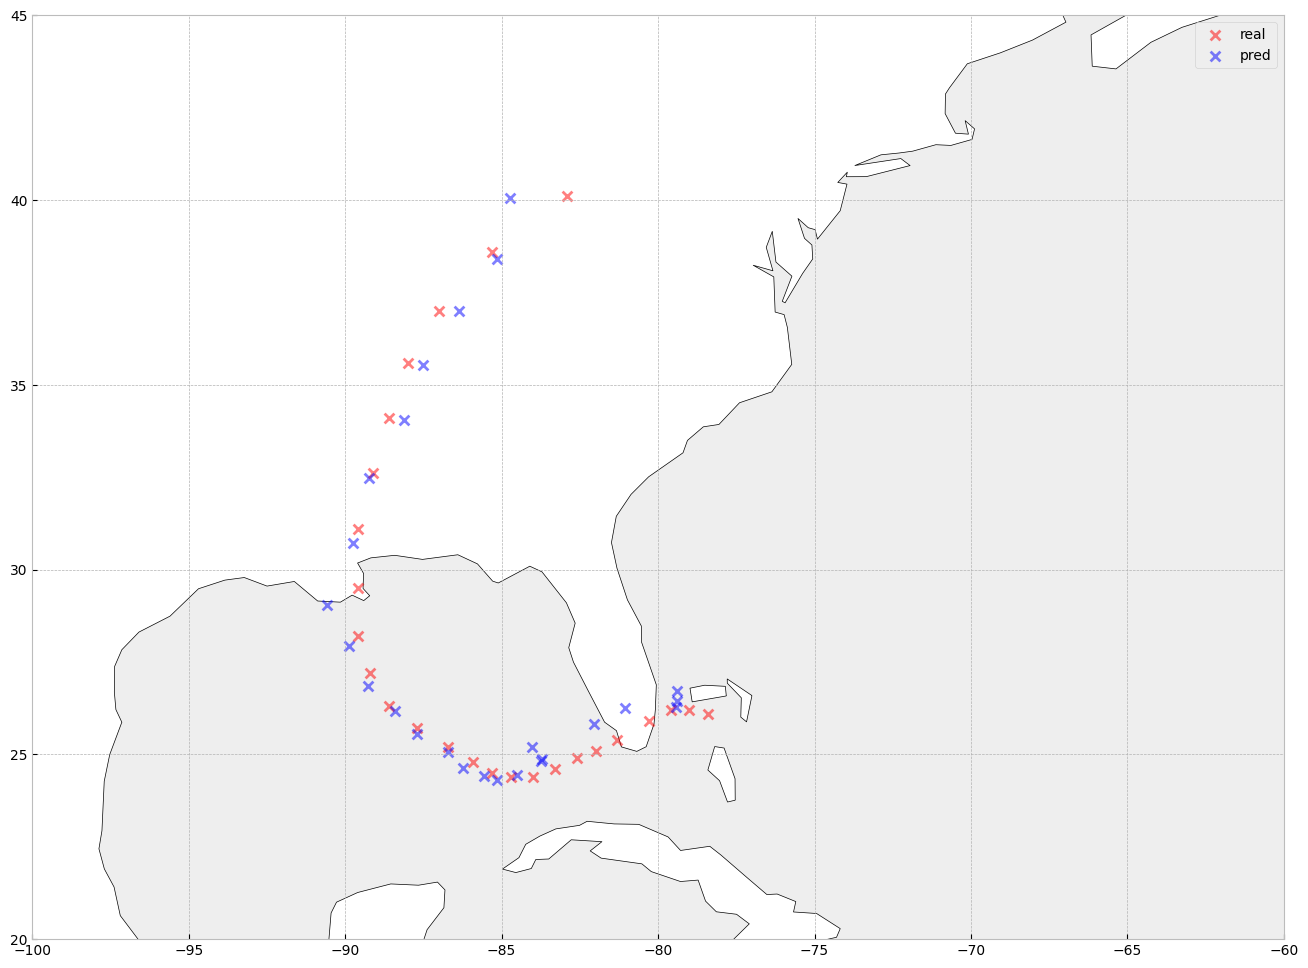

In [ ]:
ax = world.plot(color="white", edgecolor="black", figsize=(25,12))
gdf_real.plot(ax=ax, c="r", markersize=50, marker="x", alpha=0.5)
gdf_pred.plot(ax=ax, c="b", markersize=50, marker="x", alpha=0.5)
plt.xlim(-95, -70)
plt.ylim(20, 45)
plt.legend(['real', 'pred'])

plt.show()

# Classify Hurricanes

In [ ]:
gdf.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,y,relative_time,month,hour,vec_x,vec_y,vec_len,vec_direction,wind_scaled,pressure_scaled
19745,EP012004,AGATHA,,TD,15.4,-108.5,30.0,1006.0,0.0,0.0,...,0.198666,0.391393,0.363636,6,0.011111,-0.002501,0.011389,1.792170,-0.636358,0.582074
19746,EP012004,AGATHA,,TS,16.0,-109.1,35.0,1005.0,75.0,75.0,...,0.196999,0.392077,0.363636,12,0.009524,-0.001667,0.009669,1.744089,-0.439582,0.526924
19747,EP012004,AGATHA,,TS,16.6,-109.6,45.0,1000.0,75.0,75.0,...,0.195610,0.392760,0.363636,18,0.009524,-0.001389,0.009625,1.715649,-0.046029,0.251173
19748,EP012004,AGATHA,,TS,17.1,-109.9,50.0,997.0,75.0,75.0,...,0.194776,0.393443,0.363636,0,0.007937,-0.000834,0.007980,1.675442,0.150748,0.085723
19749,EP012004,AGATHA,,TS,17.5,-110.1,45.0,1000.0,50.0,50.0,...,0.194221,0.394126,0.363636,6,0.006349,-0.000556,0.006373,1.658098,-0.046029,0.251173


In [ ]:
new_df = gdf[['ID', "Status", "wind_scaled", "pressure_scaled", "x", "y", "month"]]

In [ ]:
new_df.head()

,ID,Status,wind_scaled,pressure_scaled,x,y,month
19745,EP012004,TD,-0.636358,0.582074,0.149206,0.198666,0.363636
19746,EP012004,TS,-0.439582,0.526924,0.158730,0.196999,0.363636
19747,EP012004,TS,-0.046029,0.251173,0.168254,0.195610,0.363636
19748,EP012004,TS,0.150748,0.085723,0.176190,0.194776,0.363636
19749,EP012004,TS,-0.046029,0.251173,0.182540,0.194221,0.363636


add history window

In [ ]:
col_list_status = [
    'wind_scaled',
    'pressure_scaled',
    'x',
    'y'
]

In [ ]:
new_df_lagged = create_lagged_features(new_df, col_list_status, 4)

In [ ]:
new_df_lagged.head()

,ID,Status,wind_scaled,pressure_scaled,x,y,month,wind_scaled_lag_1,pressure_scaled_lag_1,x_lag_1,...,x_lag_2,y_lag_2,wind_scaled_lag_3,pressure_scaled_lag_3,x_lag_3,y_lag_3,wind_scaled_lag_4,pressure_scaled_lag_4,x_lag_4,y_lag_4
19749,EP012004,TS,-0.046029,0.251173,0.182540,0.194221,0.363636,0.150748,0.085723,0.176190,...,0.168254,0.195610,-0.439582,0.526924,0.158730,0.196999,-0.636358,0.582074,0.149206,0.198666
19750,EP012004,TS,-0.242805,0.361474,0.188889,0.193665,0.363636,-0.046029,0.251173,0.182540,...,0.176190,0.194776,-0.046029,0.251173,0.168254,0.195610,-0.439582,0.526924,0.158730,0.196999
19751,EP012004,TS,-0.439582,0.361474,0.193651,0.193109,0.363636,-0.242805,0.361474,0.188889,...,0.182540,0.194221,0.150748,0.085723,0.176190,0.194776,-0.046029,0.251173,0.168254,0.195610
19752,EP012004,TD,-0.636358,0.416624,0.198413,0.192553,0.363636,-0.439582,0.361474,0.193651,...,0.188889,0.193665,-0.046029,0.251173,0.182540,0.194221,0.150748,0.085723,0.176190,0.194776
19753,EP012004,TD,-0.833135,0.526924,0.201587,0.192276,0.363636,-0.636358,0.416624,0.198413,...,0.193651,0.193109,-0.242805,0.361474,0.188889,0.193665,-0.046029,0.251173,0.182540,0.194221


split data

In [ ]:
X = new_df_lagged.iloc[:, 2:]
y = new_df_lagged.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define confusion matrix setup

def confusion_matrix(model, X_train, y_train, X_test, y_test):
    print("Model Results\n")
    print("Training:")
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)
    plt.grid(False)
    plt.show()
    print("Testing:")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.grid(False)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


def smote(X,y):
    # Encode y values to numeric
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=4)

    X_resampled, y_resampled_encoded = smote.fit_resample(X, y_encoded)

    # Decode y_resampled back to original labels
    y_resampled = label_encoder.inverse_transform(y_resampled_encoded)

    print("\nBefore class distribution:")
    print(pd.Series(y).value_counts())

    print("\nResampled class distribution:")
    print(pd.Series(y_resampled).value_counts())

    return X_resampled, y_resampled

In [ ]:
smote_X_train, smote_y_train = smote(X_train, y_train)


Before class distribution:
Status
TS    2731
HU    1975
LO    1682
TD     910
EX     551
DB     168
SS      61
WV      35
SD      13
PT       5
ST       5
Name: count, dtype: int64

Resampled class distribution:
HU    2731
EX    2731
TS    2731
LO    2731
TD    2731
SS    2731
DB    2731
PT    2731
WV    2731
ST    2731
SD    2731
Name: count, dtype: int64


In [ ]:
print(pd.Series(y_test).value_counts())

Status
TS    665
HU    481
LO    439
TD    228
EX    145
DB     52
WV     11
SS      9
SD      2
ST      1
PT      1
Name: count, dtype: int64


In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(smote_X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# Hyperparameter Tuning

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
rf_grid = {
    'n_estimators': randint(75, 120),
    'max_depth': randint(15, 20),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True],
    'max_features': ['sqrt']
}

randomized_search_rf = HalvingRandomSearchCV(estimator = RandomForestClassifier(), param_distributions = rf_grid, cv = 5, n_iter = 100, scoring='accuracy', n_jobs=-1)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79f6aa6484d0>,
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79f6aa5b6ed0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79f6aa372490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79f6aa648210>},
                   scoring='accuracy')
Best Parameters: {'bootstrap': True, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 97}
Best Cross-Validation Score: 0.

In [ ]:
%time randomized_search_rf.fit(smote_X_train, smote_y_train)

In [ ]:
print(f"Best Parameters: {randomized_search_rf.best_params_}")
print(f"Best Cross-Validation Score: {randomized_search_rf.best_score_}")

In [ ]:
param_dist_svc = {
    'C': np.logspace(-2, 3, 10),  # Regularization strength (0.01 to 1000)
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 2, 10)),  # Kernel coefficient
    'kernel': ['linear', 'rbf']
}

svc = SVC()
random_search_svc = HalvingRandomSearchCV(svc, param_distributions=param_dist_svc,
                                       n_iter=60, cv=5, scoring='accuracy', random_state=42)

In [ ]:
%time random_search_svc.fit(X_train_scaled, smote_y_train)

In [ ]:
print(f"Best Parameters: {random_search_svc.best_params_}")
print(f"Best Cross-Validation Score: {random_search_svc.best_score_}")

In [ ]:
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50)],  # Different layer structures
    'activation': ['relu', 'tanh'],  # 'relu' is best for deep models, 'tanh' can sometimes work better for small datasets
    'solver': ['adam', 'sgd'],  # 'adam' is faster, 'sgd' might generalize better
    'alpha': np.logspace(-5, -1, 10),  # L2 regularization (helps with overfitting)
    'learning_rate': 'adaptive',  # 'adaptive' can adjust the LR dynamically
    'learning_rate_init': np.logspace(-4, -1, 10),  # Initial LR (small values work better for convergence)
    'max_iter': [750, 900, 1000],  # Increase iterations for better training
}

mlp = MLPClassifier(random_state=42, warm_start=True)
random_search_mlp = HalvingRandomSearchCV(mlp, param_distributions=param_dist_mlp,
                                       n_iter=40, cv=5, scoring='accuracy', random_state=42)

In [ ]:
%time random_search_mlp.fit(X_train_scaled, smote_y_train)

In [ ]:
print(f"Best Parameters: {random_search_mlp.best_params_}")
print(f"Best Cross-Validation Score: {random_search_mlp.best_score_}")

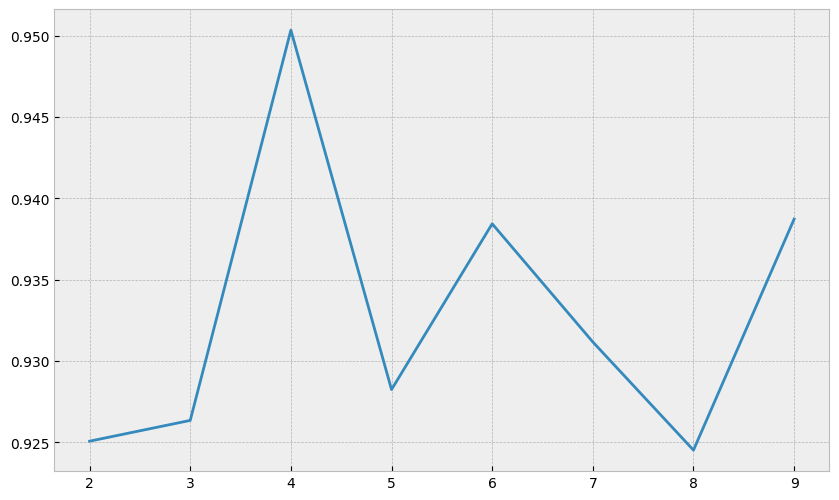

In [ ]:
accuracy_values = []
for window_size in range(2, 10):
  new_df_lagged = create_lagged_features(new_df, col_list_status, window_size)
  X = new_df_lagged.iloc[:, 2:]
  y = new_df_lagged.iloc[:, 1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # smote_X_train, smote_y_train = smote(X_train, y_train)

  model_rf.fit(X_train, y_train)

  predictions = model_rf.predict(X_test)

  accuracy_values.append(accuracy_score(y_test, predictions))

plt.figure(figsize=(10,6))
plt.plot(range(2, 10), accuracy_values)

Best accuracy for random forest with window size 4

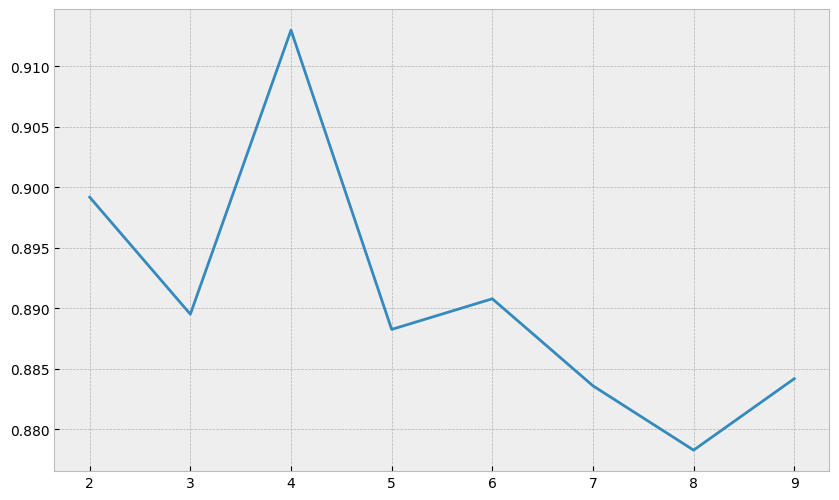

In [ ]:
accuracy_values = []
for window_size in range(2, 10):
  new_df_lagged = create_lagged_features(new_df, col_list_status, window_size)
  X = new_df_lagged.iloc[:, 2:]
  y = new_df_lagged.iloc[:, 1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # smote_X_train, smote_y_train = smote(X_train, y_train)

  model_svc.fit(X_train, y_train)

  predictions = model_svc.predict(X_test)

  accuracy_values.append(accuracy_score(y_test, predictions))

plt.figure(figsize=(10,6))
plt.plot(range(2, 10), accuracy_values)

Best accuracy for SVC with window size 4

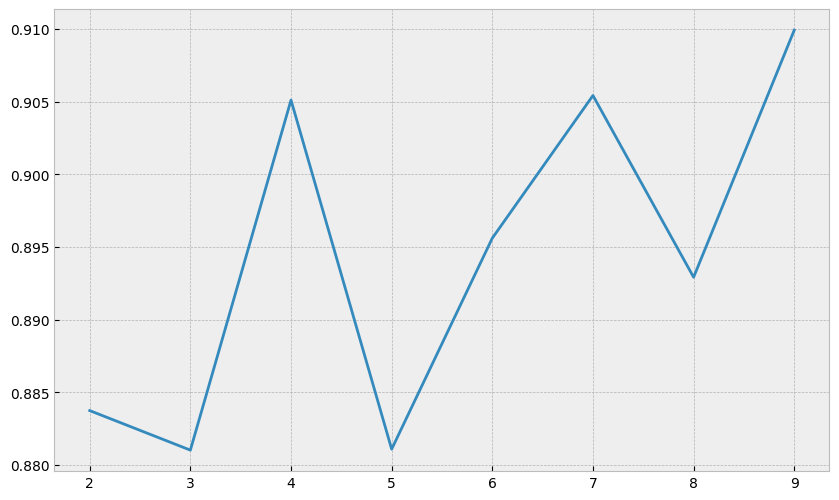

In [ ]:
accuracy_values = []
for window_size in range(2, 10):
  new_df_lagged = create_lagged_features(new_df, col_list_status, window_size)
  X = new_df_lagged.iloc[:, 2:]
  y = new_df_lagged.iloc[:, 1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # smote_X_train, smote_y_train = smote(X_train, y_train)

  model_mlp.fit(X_train, y_train)

  predictions = model_mlp.predict(X_test)

  accuracy_values.append(accuracy_score(y_test, predictions))

plt.figure(figsize=(10,6))
plt.plot(range(2, 10), accuracy_values)

# Implement ML CLassifiers

              precision    recall  f1-score   support

          DB       1.00      1.00      1.00      2731
          EX       1.00      1.00      1.00      2731
          HU       1.00      1.00      1.00      2731
          LO       1.00      0.99      1.00      2731
          PT       1.00      1.00      1.00      2731
          SD       1.00      1.00      1.00      2731
          SS       0.98      1.00      0.99      2731
          ST       1.00      1.00      1.00      2731
          TD       1.00      1.00      1.00      2731
          TS       1.00      0.99      0.99      2731
          WV       1.00      1.00      1.00      2731

    accuracy                           1.00     30041
   macro avg       1.00      1.00      1.00     30041
weighted avg       1.00      1.00      1.00     30041

              precision    recall  f1-score   support

          DB       0.88      0.94      0.91        52
          EX       0.77      0.89      0.82       145
          HU       0.98 

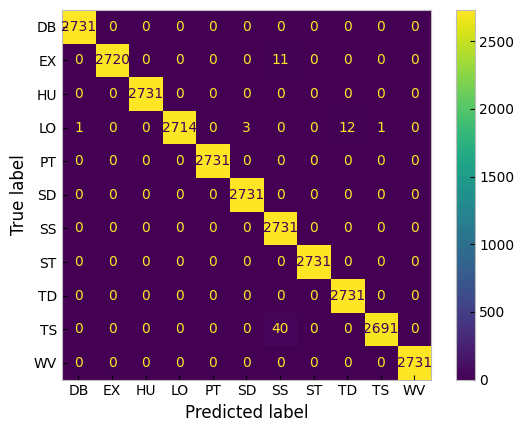

Testing:


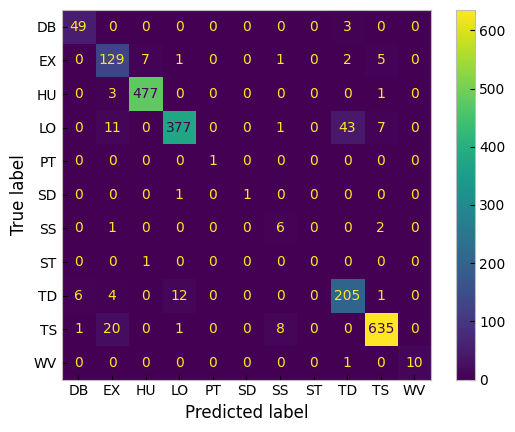

In [ ]:
# Random Forest does not need to train on scaled data

model_rf = RandomForestClassifier(max_depth=19, n_estimators=97, max_features='sqrt', bootstrap=True)

model_rf.fit(smote_X_train, smote_y_train)

train_predictions = model_rf.predict(smote_X_train)
test_predictions = model_rf.predict(X_test)
print(classification_report(smote_y_train, train_predictions))
print(classification_report(y_test, test_predictions))

confusion_matrix(model_rf, smote_X_train, smote_y_train, X_test, y_test)

              precision    recall  f1-score   support

          DB       0.99      1.00      0.99      2731
          EX       1.00      1.00      1.00      2731
          HU       1.00      1.00      1.00      2731
          LO       0.98      0.96      0.97      2731
          PT       1.00      1.00      1.00      2731
          SD       1.00      1.00      1.00      2731
          SS       1.00      1.00      1.00      2731
          ST       1.00      1.00      1.00      2731
          TD       0.97      0.98      0.97      2731
          TS       1.00      1.00      1.00      2731
          WV       1.00      1.00      1.00      2731

    accuracy                           0.99     30041
   macro avg       0.99      0.99      0.99     30041
weighted avg       0.99      0.99      0.99     30041

              precision    recall  f1-score   support

          DB       0.84      0.88      0.86        52
          EX       0.83      0.90      0.87       145
          HU       0.98 

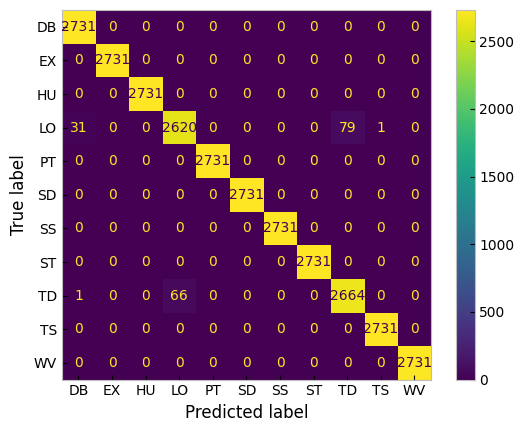

Testing:


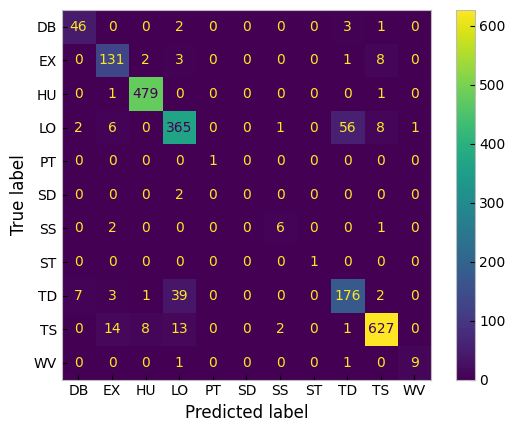

In [ ]:
model_svc = SVC(C=1000, gamma=1, kernel='rbf')

model_svc.fit(smote_X_train, smote_y_train)

train_predictions = model_svc.predict(smote_X_train)
test_predictions = model_svc.predict(X_test)
print(classification_report(smote_y_train, train_predictions))
print(classification_report(y_test, test_predictions))

confusion_matrix(model_svc, smote_X_train, smote_y_train, X_test, y_test)

              precision    recall  f1-score   support

          DB       0.92      0.99      0.96      2731
          EX       0.95      0.99      0.97      2731
          HU       1.00      1.00      1.00      2731
          LO       0.91      0.73      0.81      2731
          PT       1.00      1.00      1.00      2731
          SD       1.00      1.00      1.00      2731
          SS       0.99      1.00      0.99      2731
          ST       1.00      1.00      1.00      2731
          TD       0.85      0.92      0.88      2731
          TS       0.99      0.95      0.97      2731
          WV       0.99      1.00      1.00      2731

    accuracy                           0.96     30041
   macro avg       0.96      0.96      0.96     30041
weighted avg       0.96      0.96      0.96     30041

              precision    recall  f1-score   support

          DB       0.63      0.92      0.75        52
          EX       0.73      0.88      0.80       145
          HU       0.98 

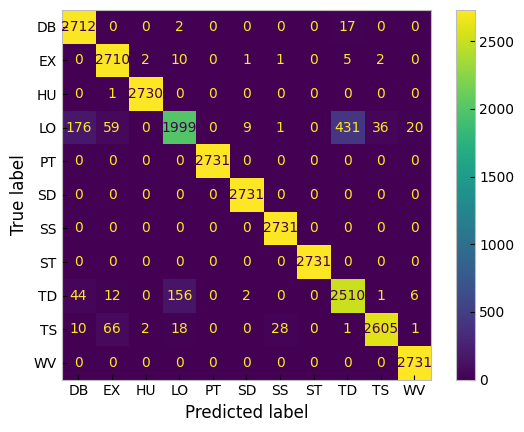

Testing:


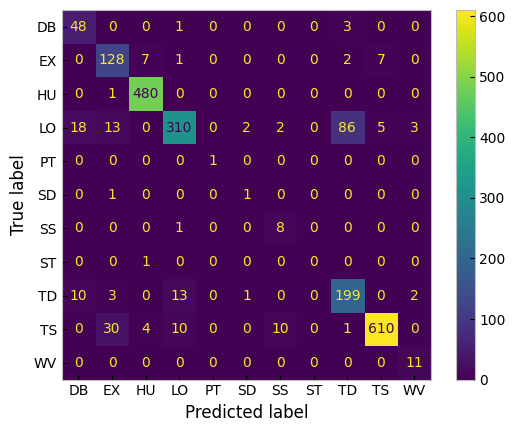

In [ ]:
model_mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=183,
              learning_rate='adaptive', max_iter=990)

model_mlp.fit(smote_X_train, smote_y_train)

train_predictions = model_mlp.predict(smote_X_train)
test_predictions = model_mlp.predict(X_test)
print(classification_report(smote_y_train, train_predictions))
print(classification_report(y_test, test_predictions))

confusion_matrix(model_mlp, smote_X_train, smote_y_train, X_test, y_test)

# Classifying Katrina Statuses

In [ ]:
gdf_kat.head()

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE_lag_5,Moderate Wind SE_lag_5,Moderate Wind SW_lag_5,Moderate Wind NW_lag_5,High Wind NE_lag_5,High Wind SE_lag_5,High Wind SW_lag_5,High Wind NW_lag_5,vec_len_lag_5,vec_direction_lag_5
44069,AL122005,KATRINA,,TS,26.1,-78.4,50.0,997.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005045,1.907558
44070,AL122005,KATRINA,,TS,26.2,-79.0,55.0,994.0,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006499,1.786212
44071,AL122005,KATRINA,,TS,26.2,-79.6,60.0,988.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011142,1.645677
44073,AL122005,KATRINA,,HU,25.9,-80.3,70.0,983.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014329,1.648439
44074,AL122005,KATRINA,,HU,25.4,-81.3,65.0,987.0,75.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009780,1.800090


In [ ]:
df_pred_status = pd.DataFrame()
df_pred_status = df_pred[["pred_wind", "pred_pressure", "pred_x", "pred_y"]]
df_pred_status = df_pred_status.rename(columns={"pred_wind": "wind_scaled", "pred_pressure": "pressure_scaled", "pred_x": "x", "pred_y": "y"})
df_pred_status["month"] = gdf_kat["month"].values
df_pred_status.insert(0, "Status", gdf_kat["Status"].values)
df_pred_status.insert(1, "ID", gdf_kat["ID"].values)

In [ ]:
def create_lagged_features_withnan(df, col_list, window_size):
    """
    Automatically creates lagged features for a given window size.

    :param df: Input time-series DataFrame
    :param window_size: Number of past time steps to use as features
    :return: Transformed DataFrame with lag features
    """
    df_copy = df.copy()
    for lag in range(1, window_size + 1):
        for col in col_list:
            df_copy[f"{col}_lag_{lag}"] = df.groupby("ID")[col].shift(lag)

    return df_copy

In [ ]:
df_pred_status = create_lagged_features_withnan(df_pred_status, col_list_status, 4)

In [ ]:
df_pred_status.head()

,Status,ID,wind_scaled,pressure_scaled,x,y,month,wind_scaled_lag_1,pressure_scaled_lag_1,x_lag_1,...,x_lag_2,y_lag_2,wind_scaled_lag_3,pressure_scaled_lag_3,x_lag_3,y_lag_3,wind_scaled_lag_4,pressure_scaled_lag_4,x_lag_4,y_lag_4
0,TS,AL122005,-0.041082,0.251709,0.329073,0.281379,0.636364,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TS,AL122005,0.071479,0.117823,0.322873,0.280356,0.636364,-0.041082,0.251709,0.329073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TS,AL122005,0.462395,-0.131480,0.322756,0.276852,0.636364,0.071479,0.117823,0.322873,...,0.329073,0.281379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HU,AL122005,0.687556,-0.309327,0.322510,0.276036,0.636364,0.462395,-0.131480,0.322756,...,0.322873,0.280356,-0.041082,0.251709,0.329073,0.281379,NaN,NaN,NaN,NaN
4,HU,AL122005,1.218769,-0.579362,0.315183,0.272245,0.636364,0.687556,-0.309327,0.322510,...,0.322756,0.276852,0.071479,0.117823,0.322873,0.280356,-0.041082,0.251709,0.329073,0.281379


In [ ]:
y_pred_status = df_pred_status.iloc[:, 0]
X_pred_status = df_pred_status.iloc[:, 2:]

In [ ]:
status_pred = model_rf.predict(X_pred_status)

In [ ]:
print(classification_report(y_pred_status, status_pred))

              precision    recall  f1-score   support

          EX       1.00      0.50      0.67         2
          HU       0.94      1.00      0.97        15
          TD       0.67      1.00      0.80         2
          TS       1.00      0.50      0.67         2

    accuracy                           0.90        21
   macro avg       0.90      0.75      0.78        21
weighted avg       0.92      0.90      0.89        21



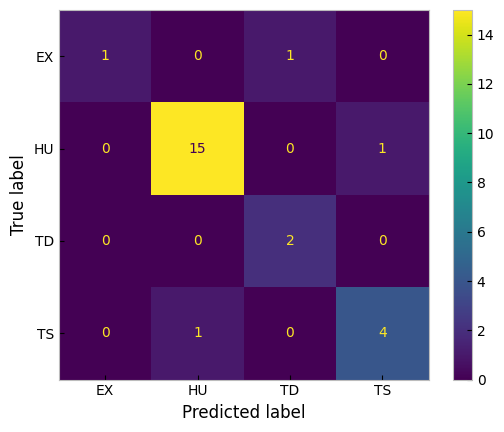

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_rf, X_pred_status, y_pred_status)
plt.grid(False)
plt.show()

In [ ]:
s_pred = {'Status': status_pred}
s_real = {'Status': df_pred_status['Status'].values}


gdf_pred_status = gpd.GeoDataFrame(s_pred, geometry=gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), crs={'init' :'epsg:4326'})
gdf_real_status = gpd.GeoDataFrame(s_real, geometry=gpd.points_from_xy(df_pred.pred_Longitude, df_pred.pred_Latitude), crs={'init': 'epsg:4326'})

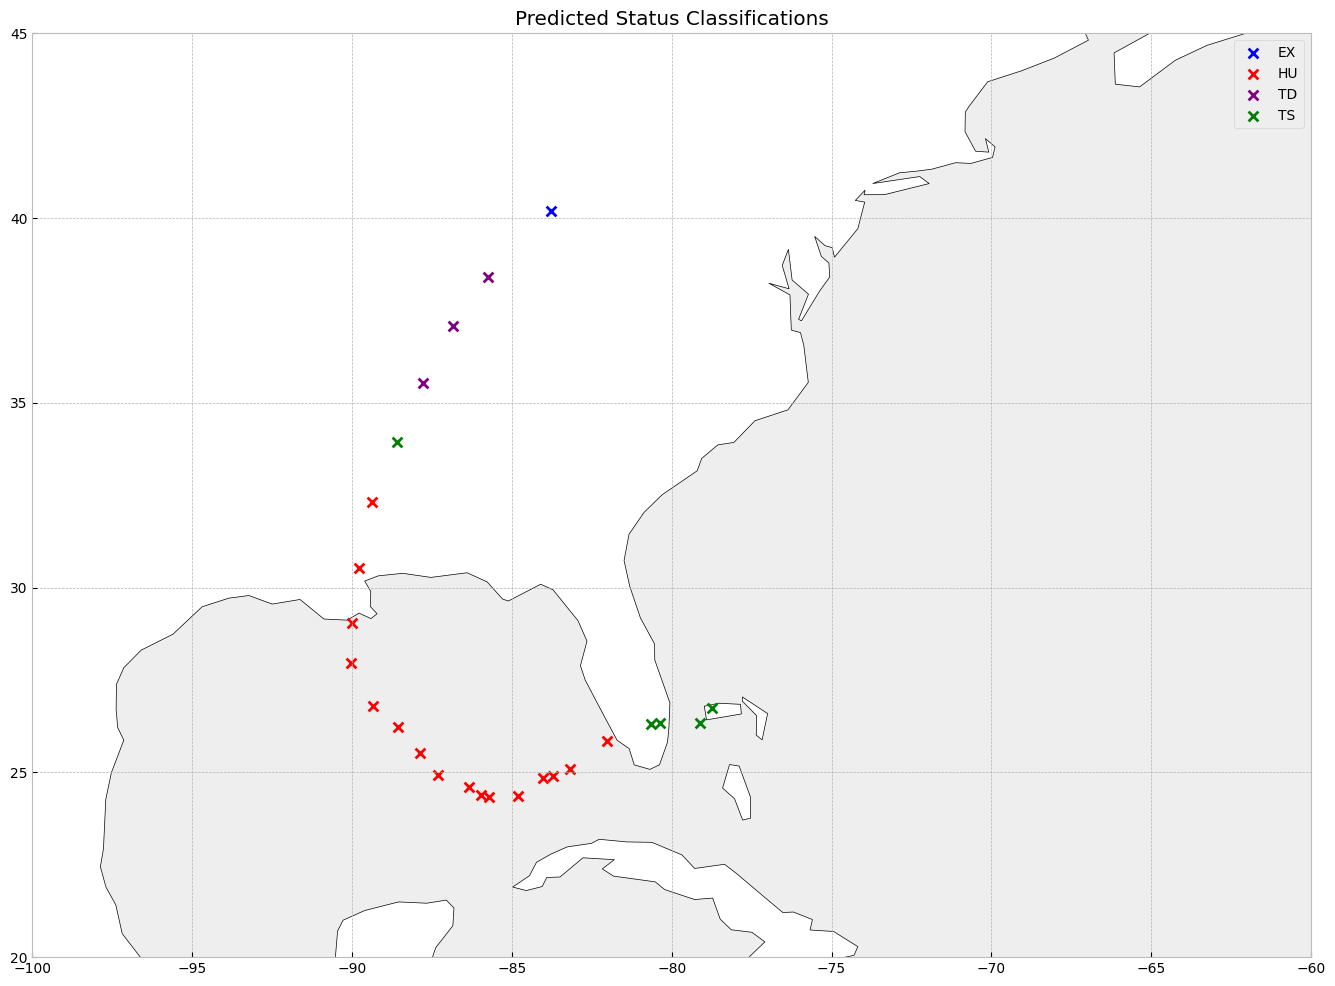

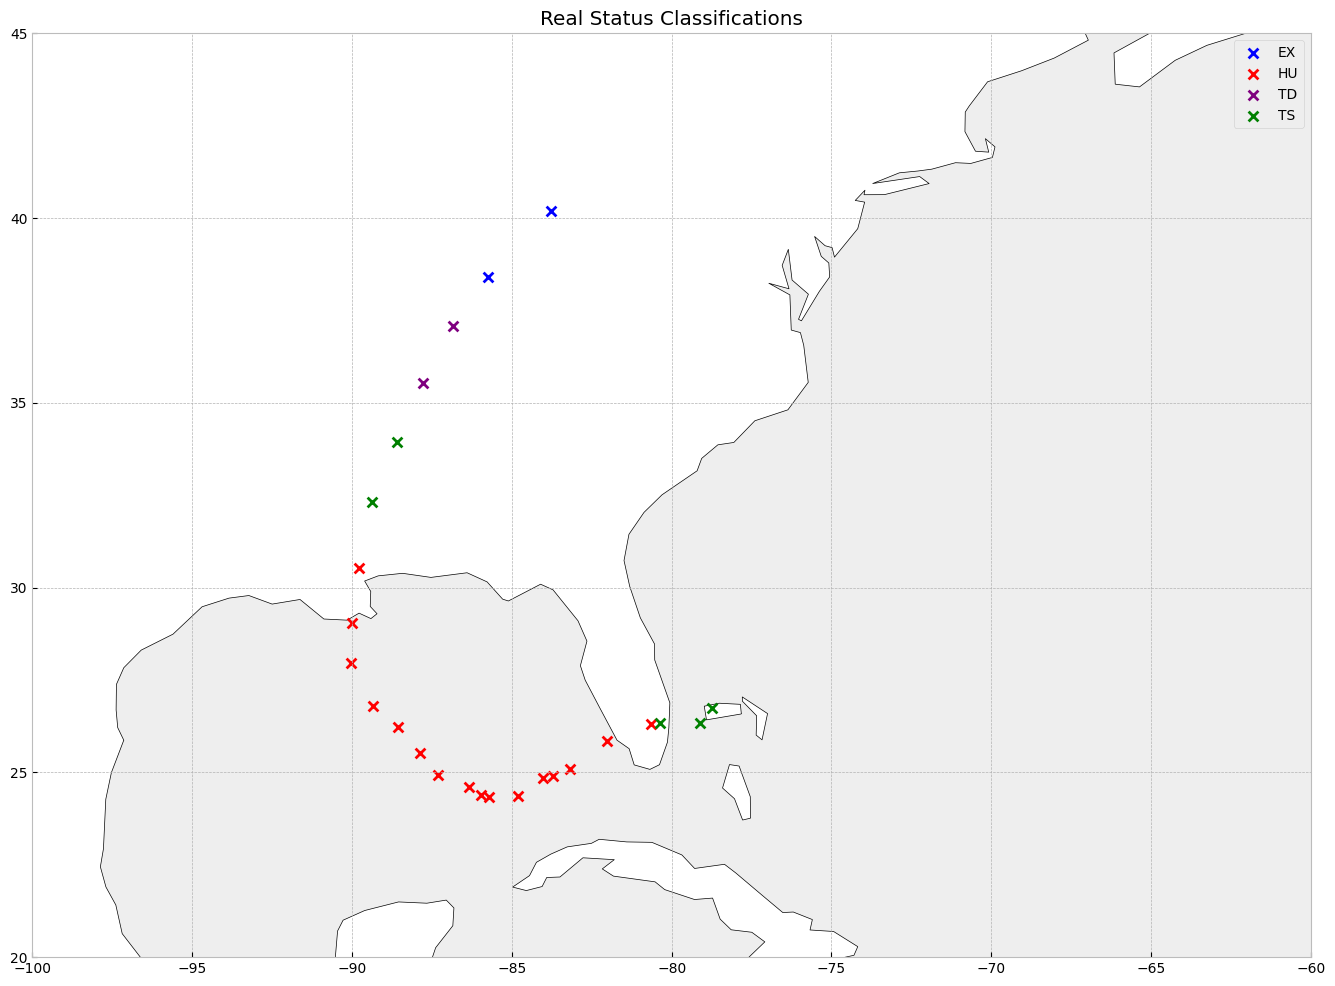

In [ ]:
status_colors = {
    "EX": "blue",
    "HU": "red",
    "TD": "purple",
    "TS": "green"
}

ax_pred = world.plot(color="white", edgecolor="black", figsize=(25,12))

# gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5) # if want to see real coordinates too
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Predicted Status Classifications')

# Group the GeoDataFrame by predicted 'Status' and plot each group separately
for status, group in gdf_pred_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_pred, label=status, markersize=50, marker="x", alpha=1, color=color)
plt.legend()
plt.show()

ax_real = world.plot(color="white", edgecolor="black", figsize=(25,12))
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Real Status Classifications')

# Group the GeoDataFrame by real 'Status' and plot each status
for status, group in gdf_real_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_real, label=status, markersize=50, marker="x", alpha=1, color=color)

plt.legend()

plt.show()

              precision    recall  f1-score   support

          EX       0.00      0.00      0.00         2
          HU       0.83      1.00      0.91        15
          TD       0.33      0.50      0.40         2
          TS       0.00      0.00      0.00         2

    accuracy                           0.76        21
   macro avg       0.29      0.38      0.33        21
weighted avg       0.63      0.76      0.69        21



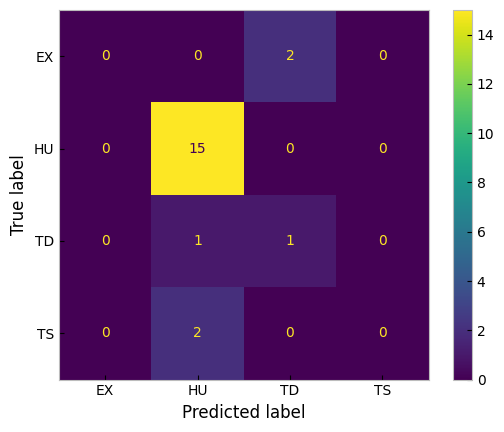

In [ ]:
status_pred = model_svc.predict(X_pred_status)
print(classification_report(y_pred_status, status_pred))

ConfusionMatrixDisplay.from_estimator(model_svc, X_pred_status, y_pred_status)
plt.grid(False)
plt.show()

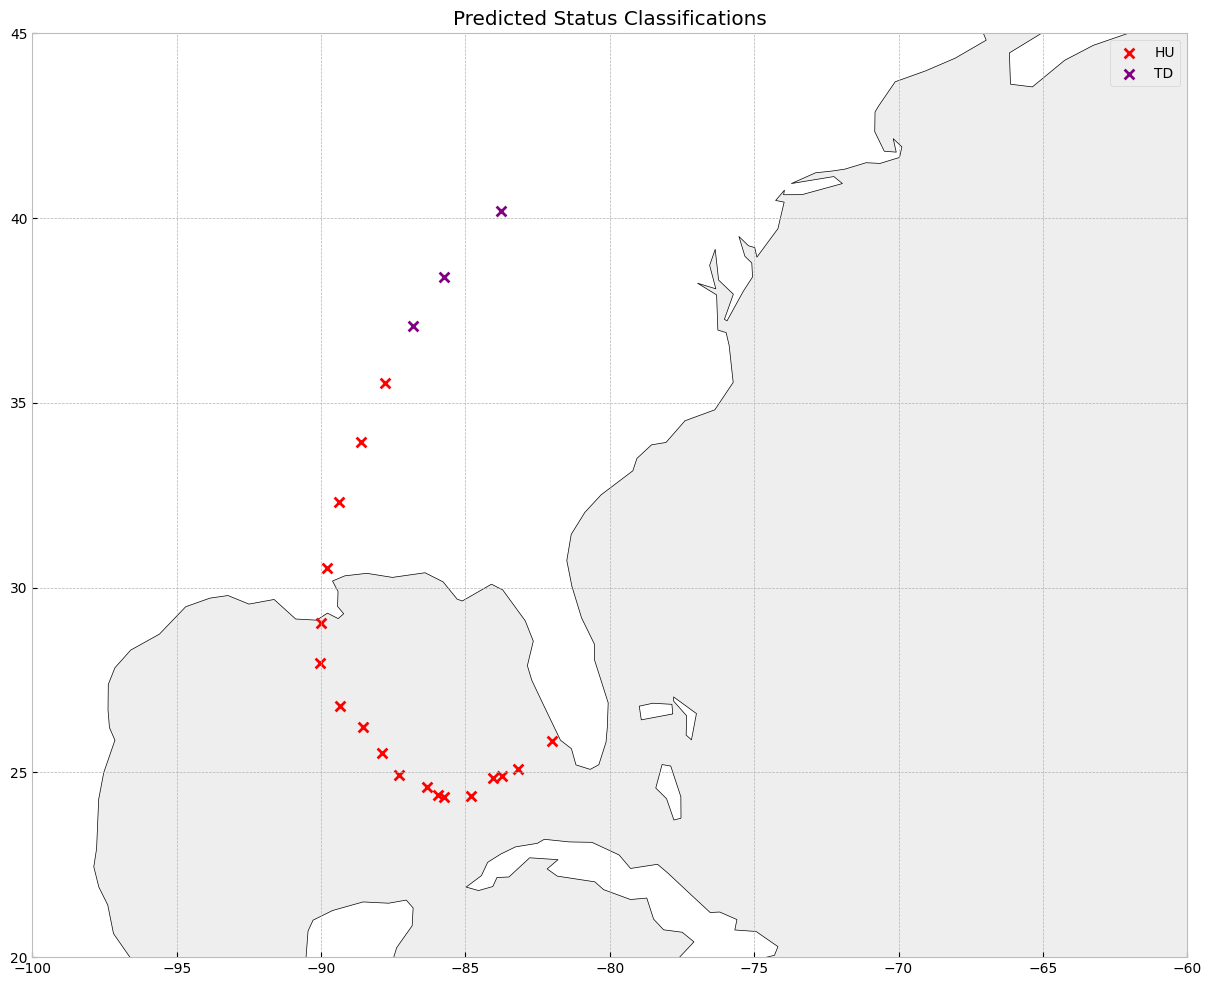

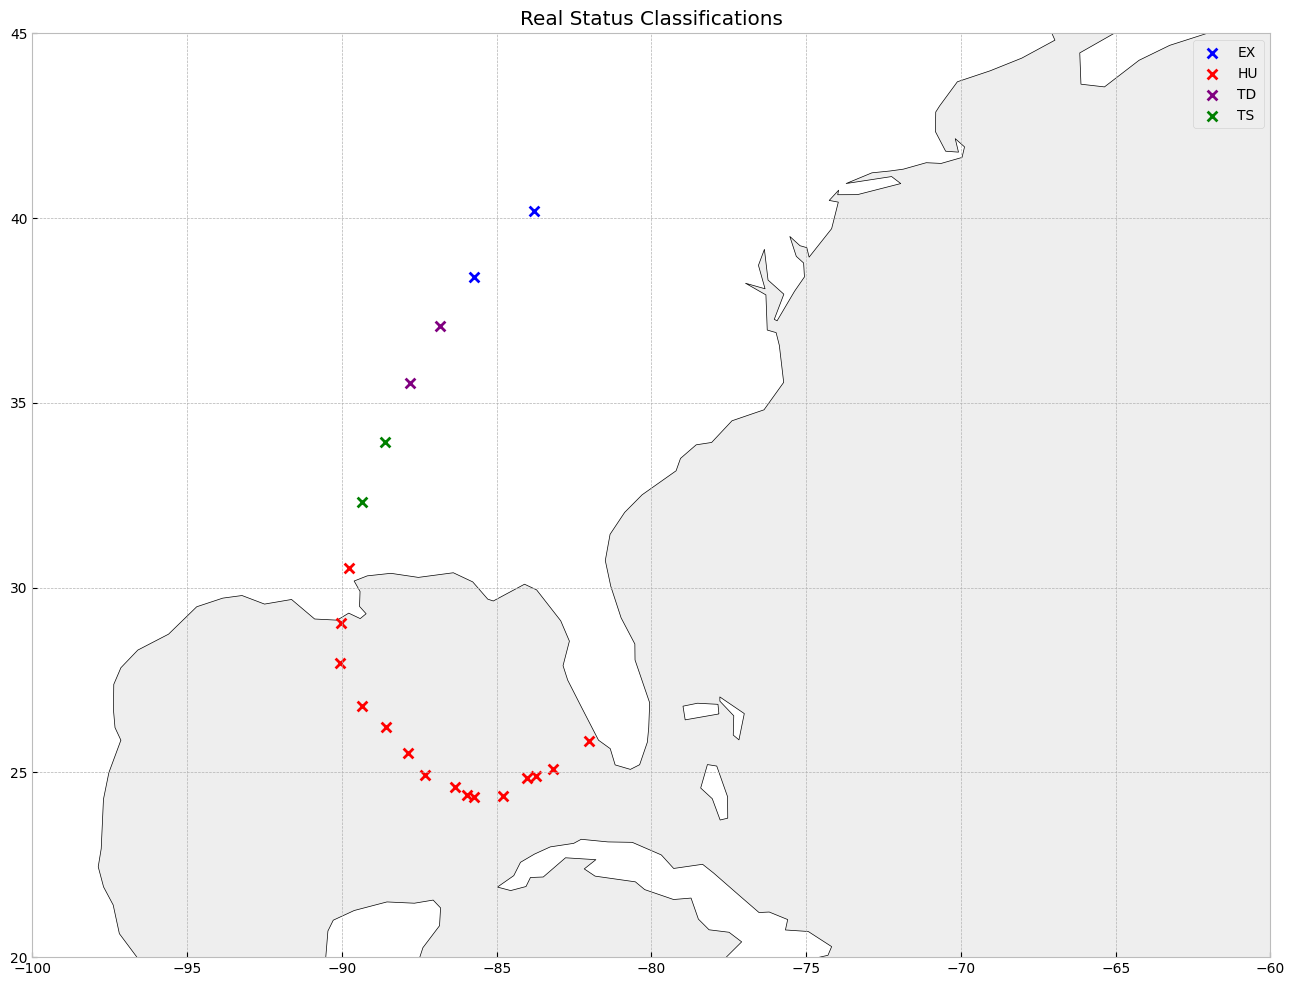

In [ ]:
s_pred = {'Status': status_pred}
s_real = {'Status': df_pred_status['Status'].values}


gdf_pred_status = gpd.GeoDataFrame(s_pred, geometry=gpd.points_from_xy(df_pred.pred_Longitude[4:],df_pred.pred_Latitude[4:]), crs={'init' :'epsg:4326'})
gdf_real_status = gpd.GeoDataFrame(s_real, geometry=gpd.points_from_xy(df_pred.pred_Longitude[4:], df_pred.pred_Latitude[4:]), crs={'init': 'epsg:4326'})

status_colors = {
    "EX": "blue",
    "HU": "red",
    "TD": "purple",
    "TS": "green"
}

ax_pred = world.plot(color="white", edgecolor="black", figsize=(25,12))

# gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5) # if want to see real coordinates too
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Predicted Status Classifications')

# Group the GeoDataFrame by predicted 'Status' and plot each group separately
for status, group in gdf_pred_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_pred, label=status, markersize=50, marker="x", alpha=1, color=color)
plt.legend()
plt.show()

ax_real = world.plot(color="white", edgecolor="black", figsize=(25,12))
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Real Status Classifications')

# Group the GeoDataFrame by real 'Status' and plot each status
for status, group in gdf_real_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_real, label=status, markersize=50, marker="x", alpha=1, color=color)

plt.legend()

plt.show()

              precision    recall  f1-score   support

          EX       1.00      0.50      0.67         2
          HU       0.94      1.00      0.97        15
          TD       0.67      1.00      0.80         2
          TS       1.00      0.50      0.67         2

    accuracy                           0.90        21
   macro avg       0.90      0.75      0.78        21
weighted avg       0.92      0.90      0.89        21



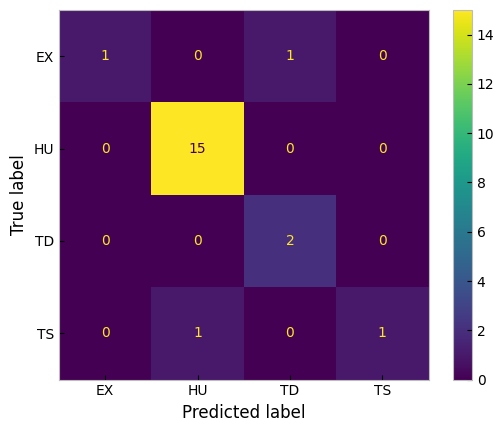

In [ ]:
status_pred = model_mlp.predict(X_pred_status)
print(classification_report(y_pred_status, status_pred))

ConfusionMatrixDisplay.from_estimator(model_mlp, X_pred_status, y_pred_status)
plt.grid(False)
plt.show()

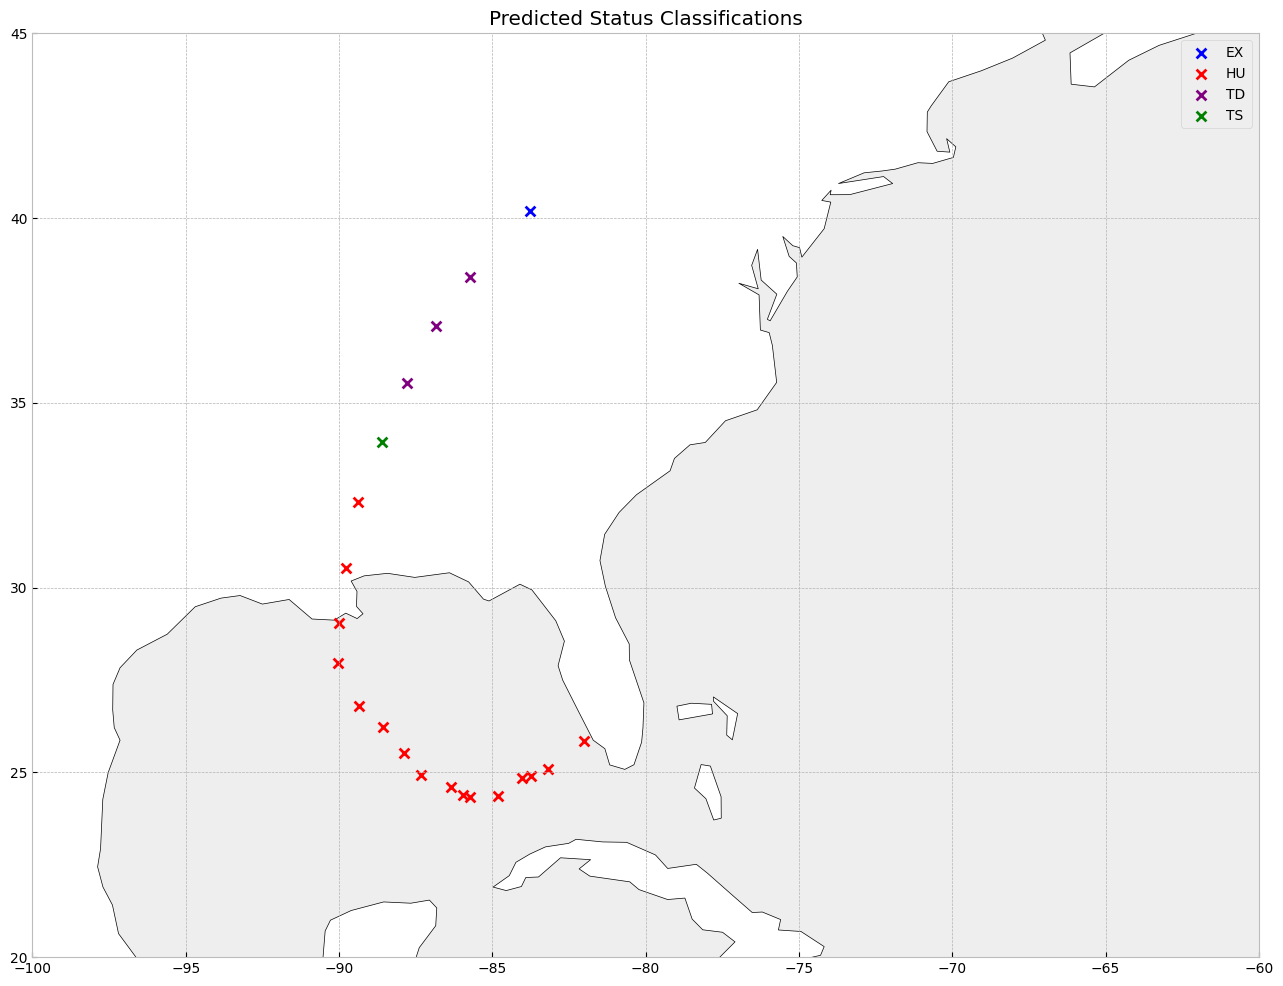

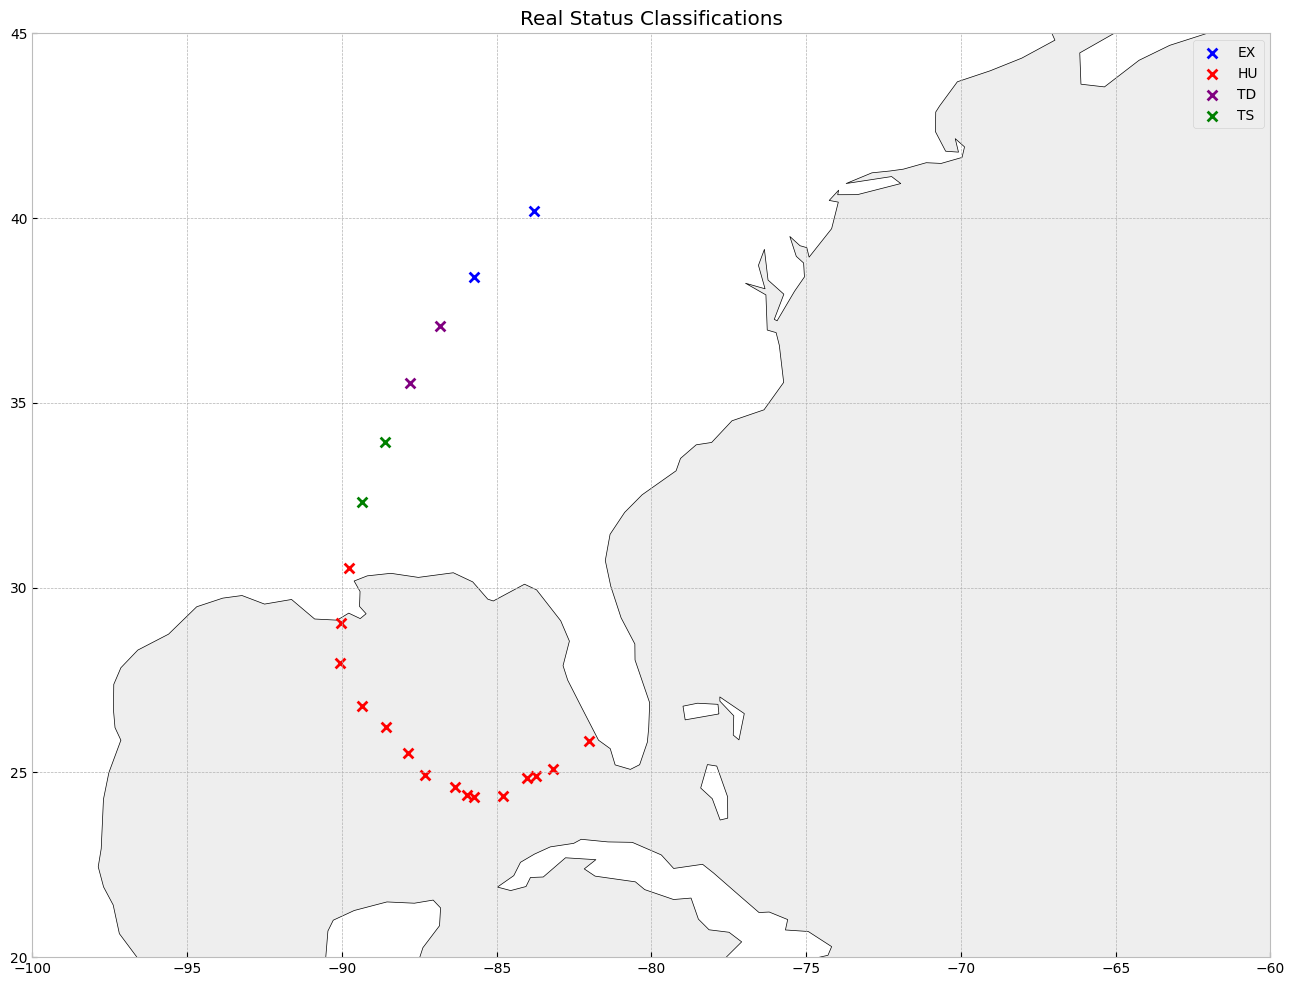

In [ ]:
s_pred = {'Status': status_pred}
s_real = {'Status': df_pred_status['Status'].values}


gdf_pred_status = gpd.GeoDataFrame(s_pred, geometry=gpd.points_from_xy(df_pred.pred_Longitude[4:],df_pred.pred_Latitude[4:]), crs={'init' :'epsg:4326'})
gdf_real_status = gpd.GeoDataFrame(s_real, geometry=gpd.points_from_xy(df_pred.pred_Longitude[4:], df_pred.pred_Latitude[4:]), crs={'init': 'epsg:4326'})

status_colors = {
    "EX": "blue",
    "HU": "red",
    "TD": "purple",
    "TS": "green"
}

ax_pred = world.plot(color="white", edgecolor="black", figsize=(25,12))

# gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5) # if want to see real coordinates too
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Predicted Status Classifications')

# Group the GeoDataFrame by predicted 'Status' and plot each group separately
for status, group in gdf_pred_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_pred, label=status, markersize=50, marker="x", alpha=1, color=color)
plt.legend()
plt.show()

ax_real = world.plot(color="white", edgecolor="black", figsize=(25,12))
plt.xlim(-100, -60)
plt.ylim(20, 45)
plt.title('Real Status Classifications')

# Group the GeoDataFrame by real 'Status' and plot each status
for status, group in gdf_real_status.groupby('Status'):
  color = status_colors.get(status, "black")  # Default to black if status is missing
  group.plot(ax=ax_real, label=status, markersize=50, marker="x", alpha=1, color=color)

plt.legend()

plt.show()